In [1]:
START_NUM=150;
END_NUM=300;

### Goal: Feature Importance.

The idea is to use the permutation importance to the neural network.
1. Fit the model with all the features of interest.
2. For each column:
  - Randomly permute the values in the column
  - Compute the drop in training RMSE
  - The more important the feature is, theoretically the more is the performance drop.

In [2]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
print(tf.__version__);
import pandas as pd;

from sklearn.preprocessing import StandardScaler;
from sklearn.preprocessing import MinMaxScaler;
from sklearn.metrics import mean_squared_error;

2.6.0


In [3]:
pd.set_option('display.max_columns', 300);
pd.set_option('display.max_rows', 300);
tf.keras.backend.set_floatx('float64');

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [5]:
MONTHS = 60;
SPLIT = 48; # 2015-2018: training, 2019: testing.
# BATCH_SIZE = 19; # used in NN_v1
BATCH_SIZE = 24;
WINDOW_SIZE = 1;

TEST_LENGTH = MONTHS - SPLIT;

### Data preparation

In [6]:
multi_data = pd.read_csv('../data/full_dataset_unscaled.csv', index_col = 0);
zip_ids = multi_data.index.unique();

multi_data.drop(["City", "State", "Metro", "CountyName", "year", "month", "datetime"],\
                 axis = 1, inplace = True);

multi_data.head()

zri  percent_white  percent_black  percent_asian  percent_hispanic  \
zip                                                                          
1013  946.0       0.714892       0.023829       0.013748          0.230129   
1013  950.0       0.715367       0.024195       0.014023          0.229024   
1013  958.0       0.715842       0.024561       0.014299          0.227919   
1013  958.0       0.716318       0.024927       0.014574          0.226813   
1013  955.0       0.716793       0.025294       0.014850          0.225708   

      percent_native_am  percent_other_race  percent_0_17  percent_18_39  \
zip                                                                        
1013           0.000113            0.004539      0.224062       0.314378   
1013           0.000226            0.004587      0.223443       0.316319   
1013           0.000339            0.004634      0.222823       0.318260   
1013           0.000452            0.004682      0.222204       0.320201   
1013           0.000565            0.004730      0.221584       0.322142   

      percent_40_64  percent_65+  percent_rental_units_vacant  \
zip                                                             
1013       0.316595     0.144965                     0.057735   
1013       0.315346     0.144892                     0.057503   
1013       0.314097     0.144820                     0.057270   
1013       0.312847     0.144748                     0.057038   
1013       0.311598     0.144675                     0.056805   

      percent_rental_units_occupied  percent_graduate_deg  percent_bachelors  \
zip                                                                            
1013                       0.942265              0.029555           0.062456   
1013                       0.942497              0.029598           0.062682   
1013                       0.942730              0.029641           0.062908   
1013                       0.942962              0.029684           0.063134   
1013                       0.943195              0.029727           0.063359   

      percent_associates  percent_highschool  percent_less_highschool  \
zip                                                                     
1013            0.257328            0.383459                 0.218492   
1013            0.255708            0.385186                 0.217890   
1013            0.254088            0.386912                 0.217289   
1013            0.252468            0.388639                 0.216687   
1013            0.250848            0.390365                 0.216086   

      percent_commute_public_transport  percent_commute_less_30  \
zip                                                               
1013                          0.022609                 0.731245   
1013                          0.023198                 0.733361   
1013                          0.023787                 0.735477   
1013                          0.024375                 0.737593   
1013                          0.024964                 0.739709   

      percent_buildings_less_10_units  percent_buildings_10_19_units  \
zip                                                                    
1013                         0.883422                       0.030202   
1013                         0.883598                       0.030477   
1013                         0.883775                       0.030752   
1013                         0.883952                       0.031027   
1013                         0.884128                       0.031302   

      percent_buildings_20_49_units  percent_buildings_50+_units  \
zip                                                                
1013                       0.036863                     0.049514   
1013                       0.036368                     0.049557   
1013                       0.035873                     0.049601   
1013                       0.035378                     0.049644   
1013            

In [7]:
FEATURES = multi_data.shape[1] - 1;

feature_name = list(multi_data.columns);

### Utility functions

In [8]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series); #(43,)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True);
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)); #(13,43)
    dataset = dataset.shuffle(shuffle_buffer)\
                     .map(lambda window: (window[:-1, 1:], window[-1][0]));
    dataset = dataset.batch(batch_size).prefetch(1);
    return dataset;

In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Frame")
    plt.ylabel("ZRI")
    plt.grid(True)

### Neural network center

In [10]:
def NN_model(dataset, termination=0, test = None):
    tf.keras.backend.clear_session();
    # dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

    class myCallbacks(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            mse = logs.get("mse");
            if(mse < termination):
                print("\nGot an mse at {:.4f} in epoch {} and stopped training\n".format(mse, epoch));
                self.model.stop_training = True;
            
    callback = myCallbacks();
    
    model = tf.keras.models.Sequential([
#         tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                           input_shape=[None]),
#       tf.keras.layers.Conv1D(filters=32, kernel_size=3,
#                           strides=1, padding="causal",
#                           activation="relu",
#                           input_shape=[None, WINDOW_SIZE, FEATURES+1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, input_shape = [None, WINDOW_SIZE, FEATURES])),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        # tf.keras.layers.SimpleRNN(8, return_sequences=True),
        #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
        tf.keras.layers.Dense(8, activation="relu"),
    #   tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1)
        # tf.keras.layers.Lambda(lambda x: x * 2.0)
    ]);
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer="adam",
                  metrics=["mae", "mse"])

    model.build((None,WINDOW_SIZE,FEATURES))
    # model.summary()

    if not test: history = model.fit(dataset, epochs=500, callbacks = [callback], verbose = 0);
    else: history = model.fit(dataset, epochs=500, validation_data=test,\
                              callbacks=[callback], verbose = 0);
    return model;

In [11]:
def NN_forecast(model, series_transformed):
    forecast = []
    results = []
    for time in range(MONTHS - WINDOW_SIZE):
        forecast.append(model.predict(series_transformed[np.newaxis, time:time + WINDOW_SIZE, 1:]))

    results = [float(x[-1][0]) for x in forecast];
    actual = list(series_transformed[WINDOW_SIZE:, 0]);
    
    return results, actual;

In [12]:
@tf.autograph.experimental.do_not_convert
def NN_test(ZONE, termination=0, plot=False):
    '''
    Input: ZONE
    Output: the RMSE of a NN model on the predicted train, partially predicted test, and complete predicted test.
    '''
    # Collection of data
    series_frame = multi_data[multi_data.index == ZONE];
    # series_frame.sort_values("datetime", ascending = True, inplace = True);
    
    # Standardization
    scaler = MinMaxScaler();
    series_transformed = scaler.fit_transform(series_frame);
    
    # Train test split
    series_train = series_transformed[:SPLIT];
    series_test = series_transformed[SPLIT-WINDOW_SIZE:];
    
    # Window the training set to make input of the NN
    dataset_train = windowed_dataset(series_train, WINDOW_SIZE, BATCH_SIZE, 60);
    # dataset_test = windowed_dataset(series_test, WINDOW_SIZE, BATCH_SIZE, 60);
    
#     for x, y in dataset_train:
#         print(np.array(x).shape, np.array(y).shape);
    
    model = NN_model(dataset_train, termination);
    
    time_train = list(range(SPLIT));
    time_test = list(range(SPLIT, MONTHS));
    
    # Forecasting
    results, actual = NN_forecast(model, series_transformed);
    
    # Compute MSE
    MSE_train = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5 * scaler.data_range_[0];
    MSE_test = mean_squared_error(actual[-TEST_LENGTH:], results[-TEST_LENGTH:])**0.5 * scaler.data_range_[0];
    
    if plot: # If the plot option is selected, plot the graph.
        time_actual = range(WINDOW_SIZE, MONTHS);
        plt.figure(figsize=(10, 6))
        plot_series(time_actual, np.array(actual)*scaler.data_range_[0]+scaler.data_min_[0]);
        plot_series(time_actual, np.array(results)*scaler.data_range_[0]+scaler.data_min_[0]);
        plt.show();

    return MSE_train, MSE_test, model, scaler, series_transformed;

### The script


Got an mse at 0.0025 in epoch 133 and stopped training



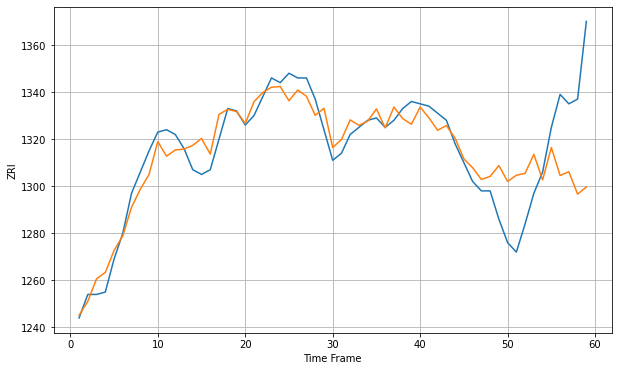

Wall time: 8.95 s
6405 6.24265729424698 31.24595096988627


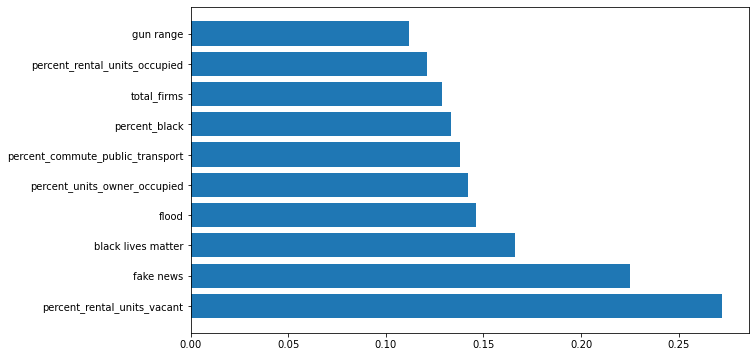


Got an mse at 0.0025 in epoch 104 and stopped training



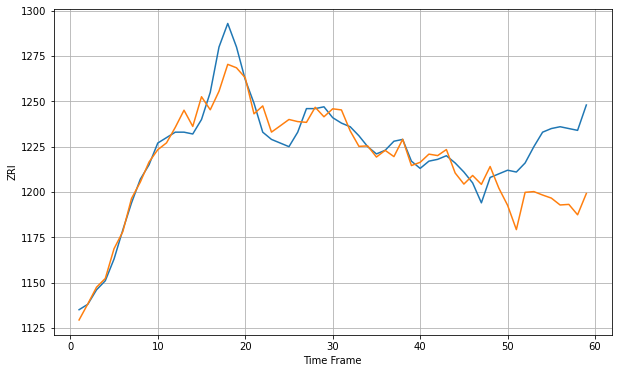

Wall time: 11.1 s
6418 7.848069637300376 33.18981100712984


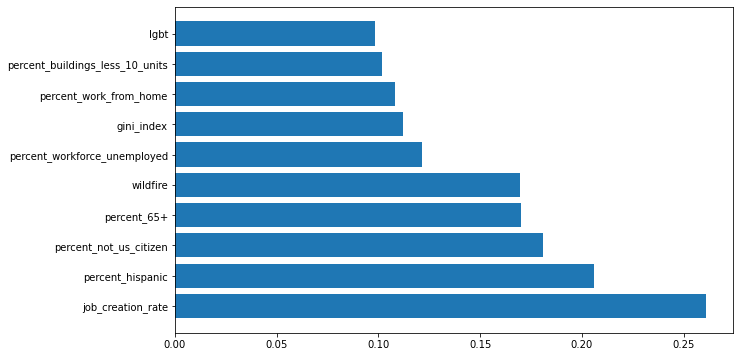


Got an mse at 0.0025 in epoch 87 and stopped training



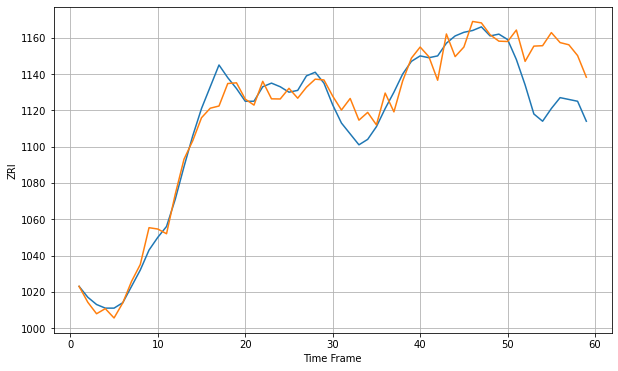

Wall time: 10.4 s
6450 7.635748644588674 26.42701190224558


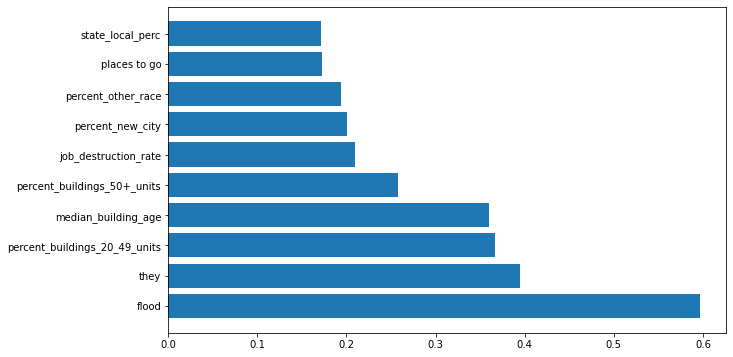


Got an mse at 0.0025 in epoch 116 and stopped training



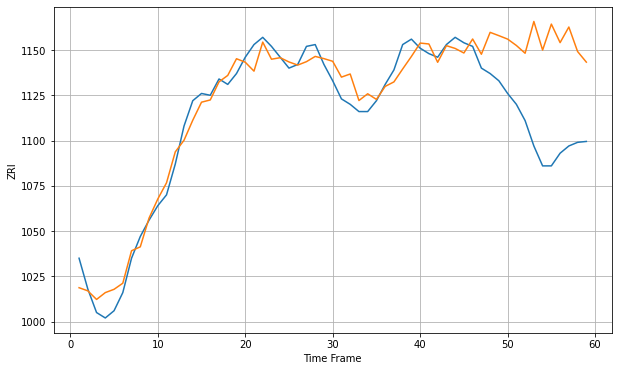

Wall time: 11.8 s
6451 7.631216480761122 51.57063730962622


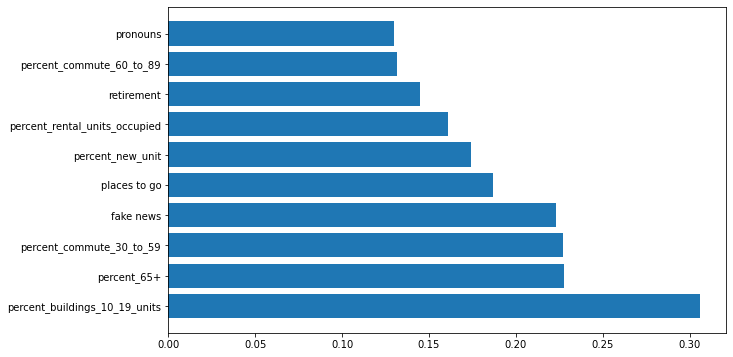


Got an mse at 0.0024 in epoch 49 and stopped training



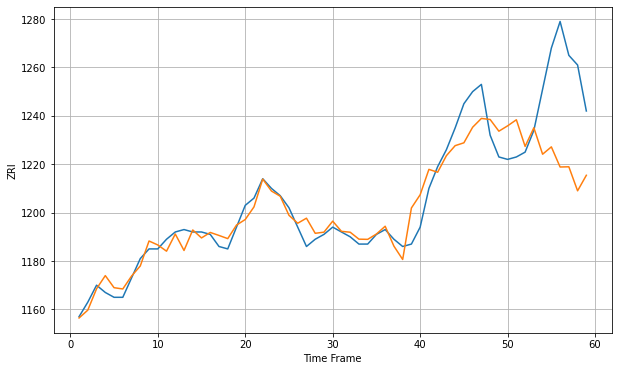

Wall time: 9.34 s
6457 6.058227972225207 31.789340740904976


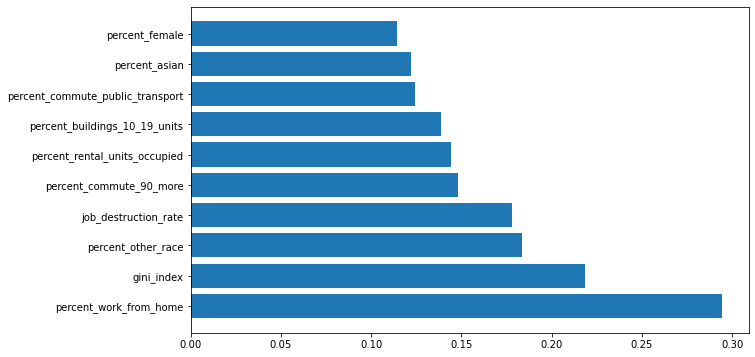


Got an mse at 0.0025 in epoch 106 and stopped training



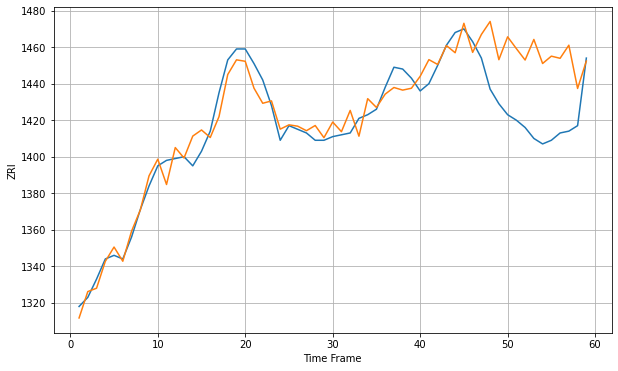

Wall time: 10.5 s
6460 7.741222137548588 38.70436280346107


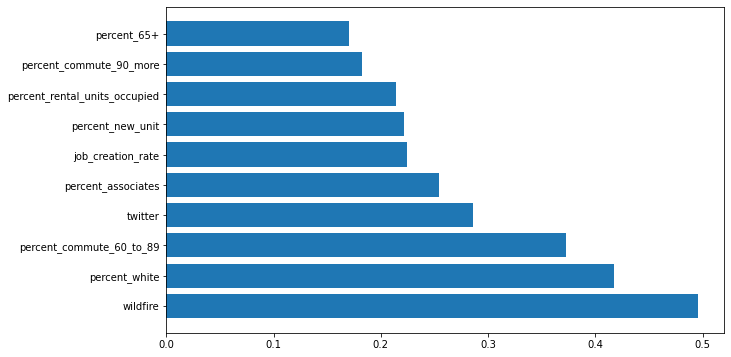


Got an mse at 0.0025 in epoch 193 and stopped training



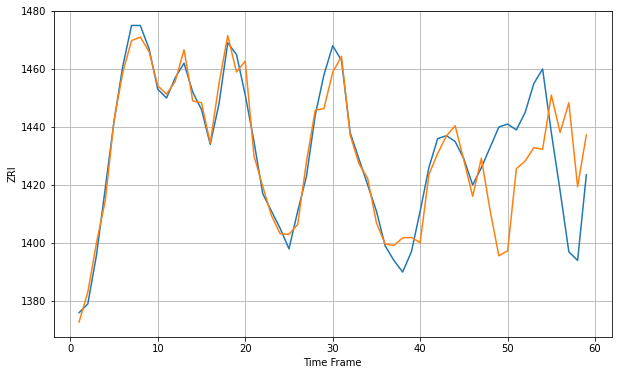

Wall time: 13.8 s
6484 4.916794528422749 29.03197967234076


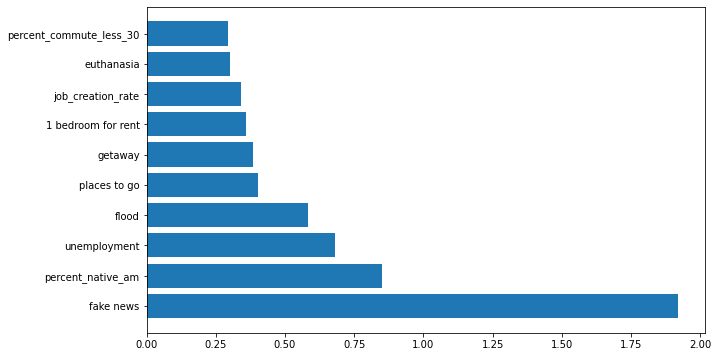


Got an mse at 0.0025 in epoch 85 and stopped training



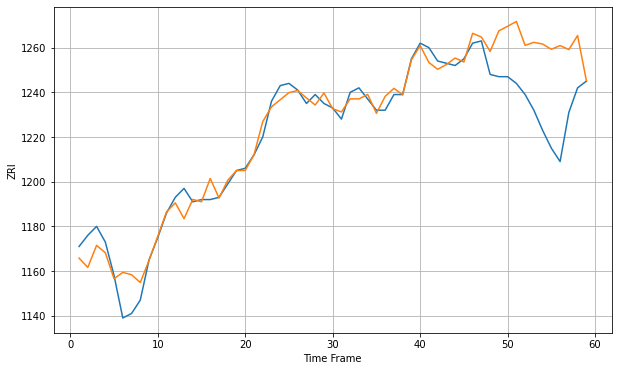

Wall time: 10.6 s
6489 6.098292752503371 29.85600319114213


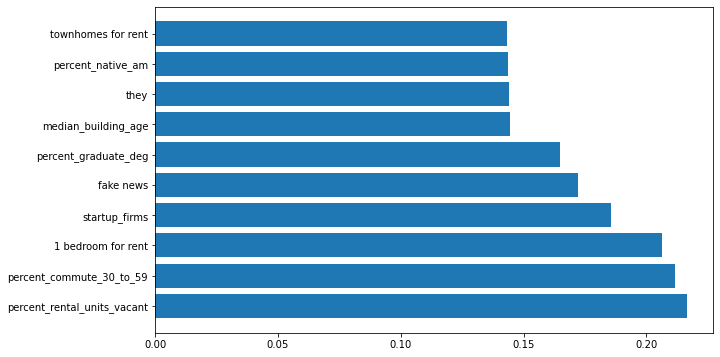


Got an mse at 0.0025 in epoch 60 and stopped training



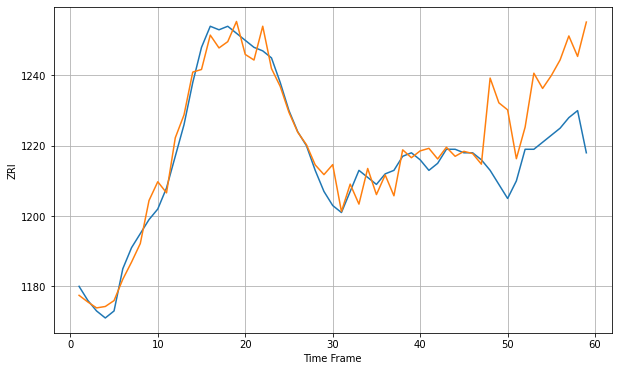

Wall time: 11 s
6492 4.0530929354014456 21.35898205045294


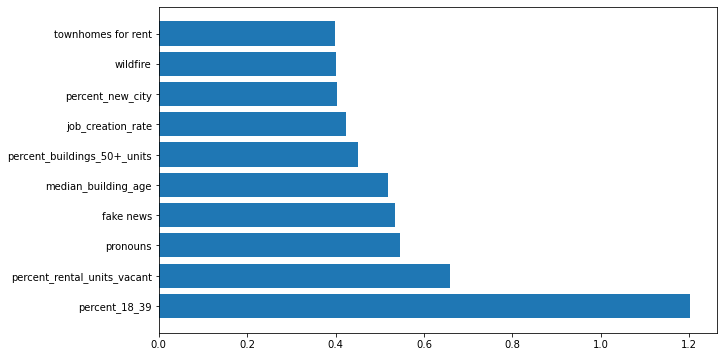


Got an mse at 0.0024 in epoch 68 and stopped training



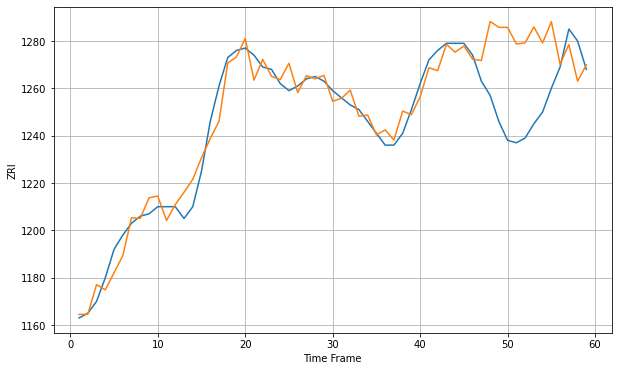

Wall time: 10 s
6511 5.944603634786491 31.416241231881955


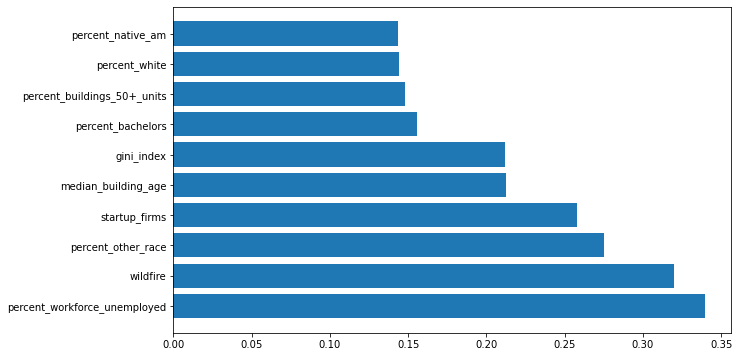


Got an mse at 0.0025 in epoch 136 and stopped training



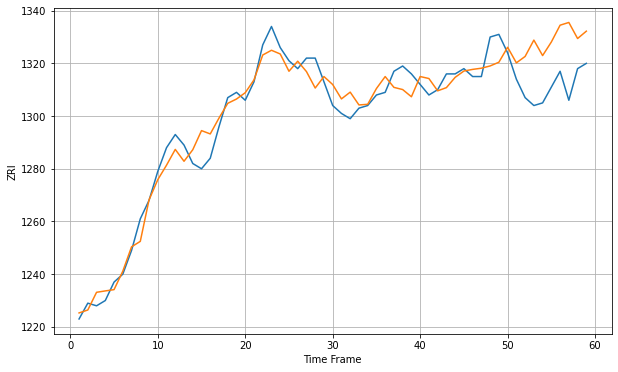

Wall time: 11.5 s
6512 5.5050368443983375 16.352412164541615


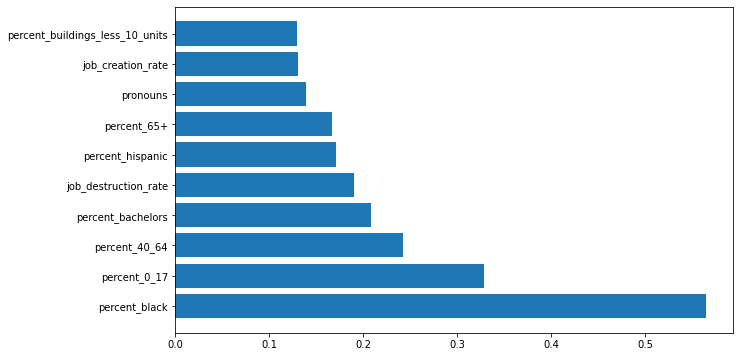


Got an mse at 0.0025 in epoch 136 and stopped training



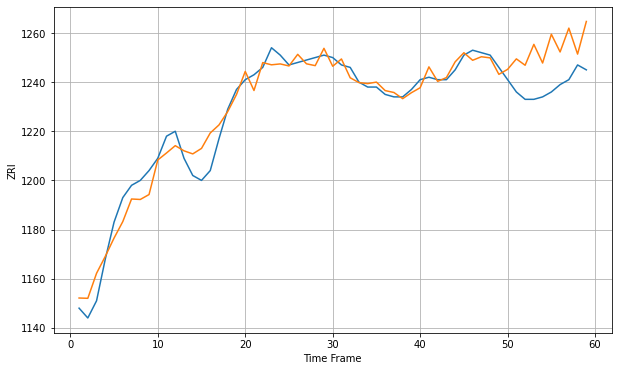

Wall time: 11.3 s
6513 5.457522554630716 14.911174475276994


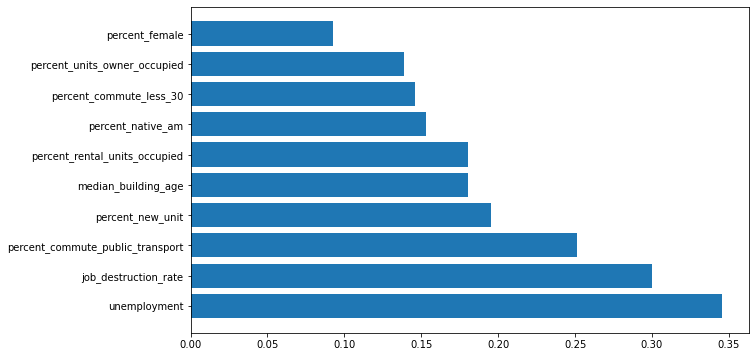


Got an mse at 0.0024 in epoch 72 and stopped training



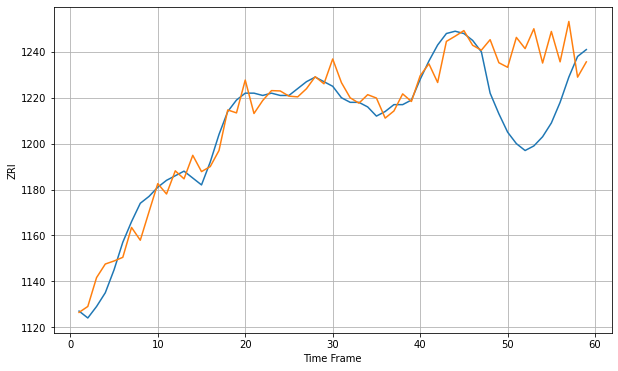

Wall time: 9.57 s
6515 6.07844113884129 31.882487299340998


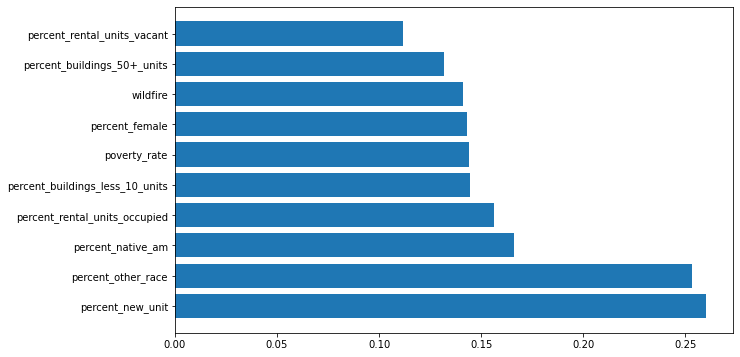


Got an mse at 0.0025 in epoch 143 and stopped training



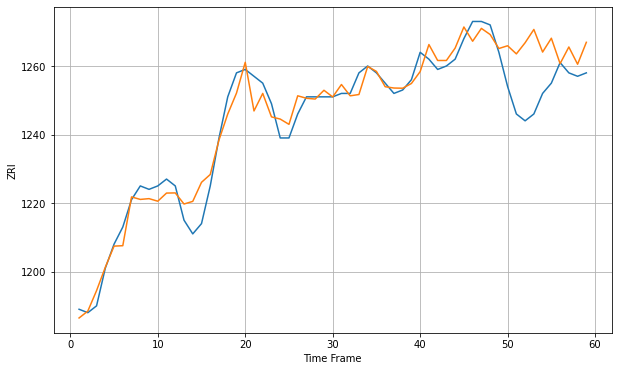

Wall time: 11.6 s
6516 4.202337755813709 13.079819092290041


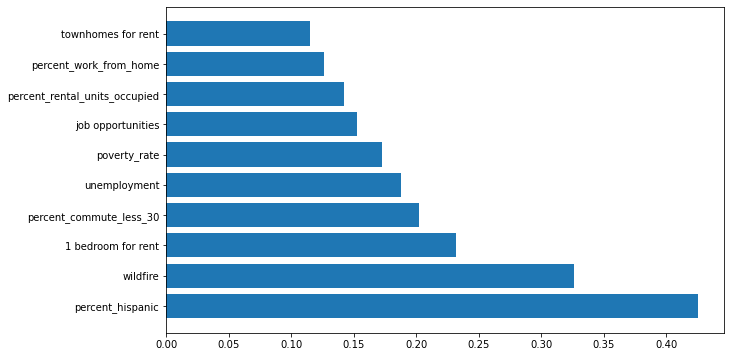


Got an mse at 0.0025 in epoch 68 and stopped training



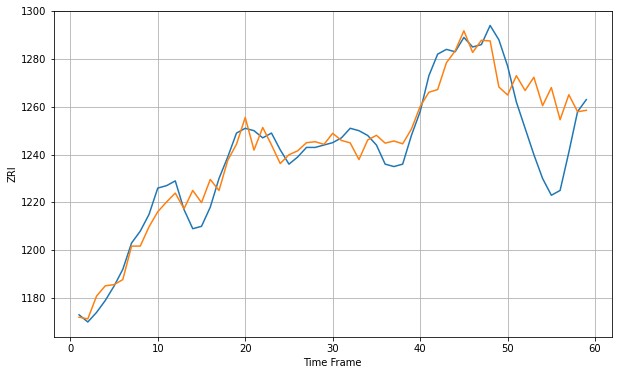

Wall time: 9.58 s
6519 6.335327908855286 23.132010962325662


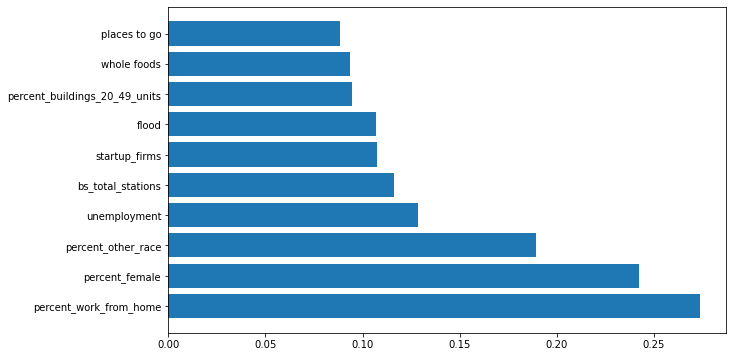


Got an mse at 0.0024 in epoch 56 and stopped training



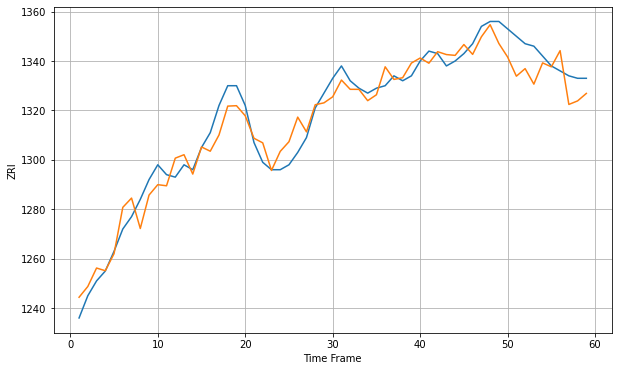

Wall time: 9.2 s
6604 5.978603616860952 9.745981483634447


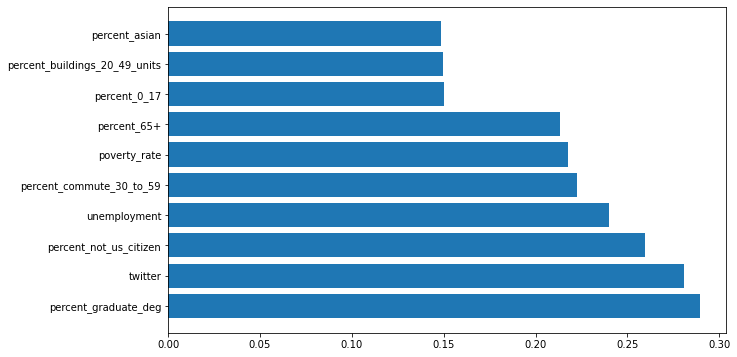


Got an mse at 0.0025 in epoch 229 and stopped training



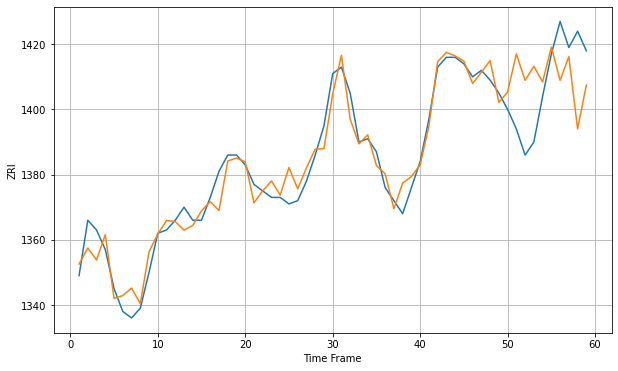

Wall time: 13.9 s
6605 4.861071733582697 15.911961585296924


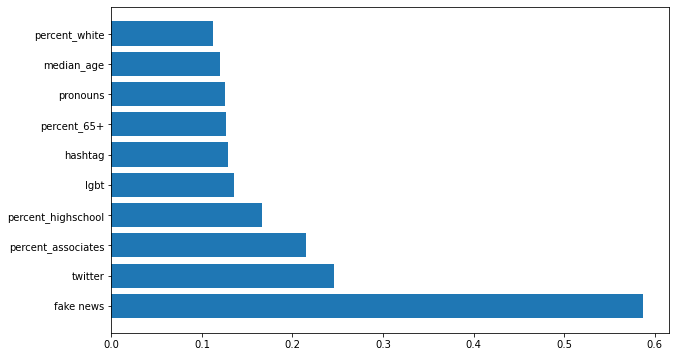


Got an mse at 0.0025 in epoch 187 and stopped training



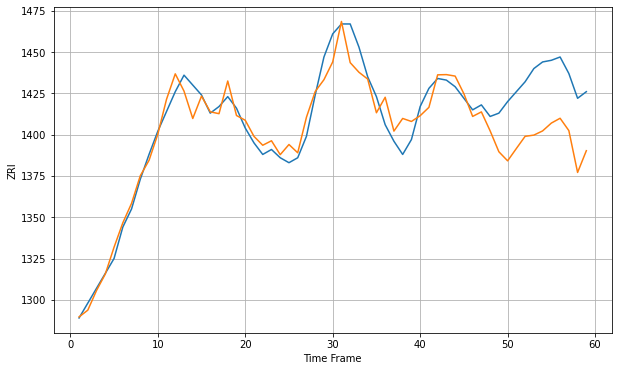

Wall time: 12.9 s
6606 8.99831618597157 35.186521940916236


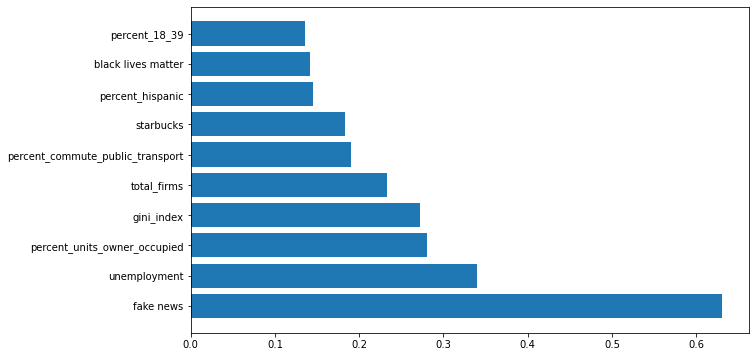


Got an mse at 0.0025 in epoch 162 and stopped training



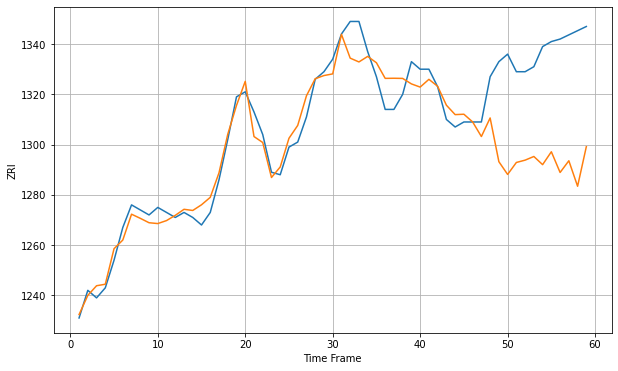

Wall time: 12.1 s
6607 6.011072155539556 44.29468004540083


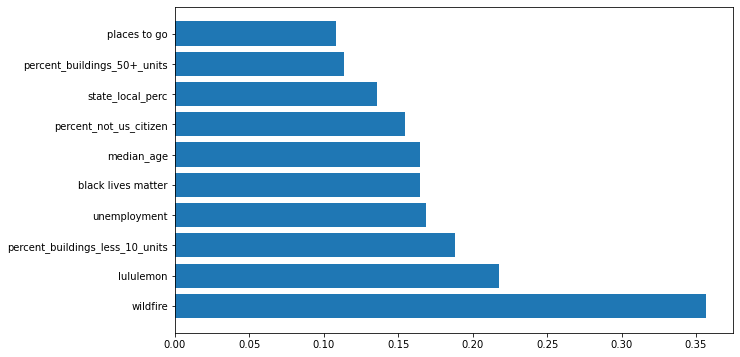


Got an mse at 0.0025 in epoch 76 and stopped training



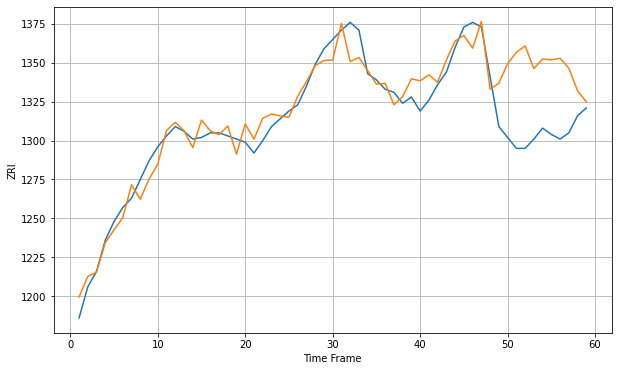

Wall time: 9.69 s
6608 9.37753886176549 43.059079128061214


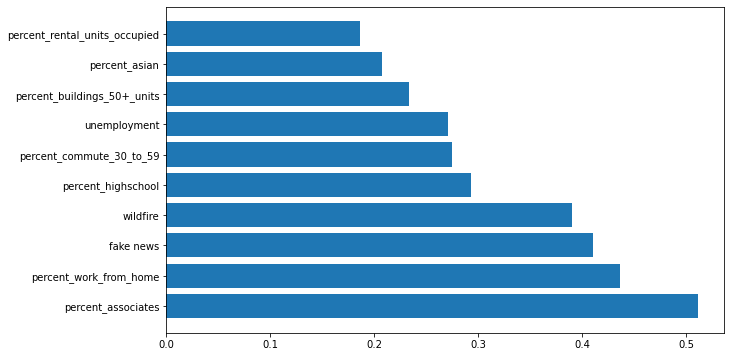


Got an mse at 0.0025 in epoch 88 and stopped training



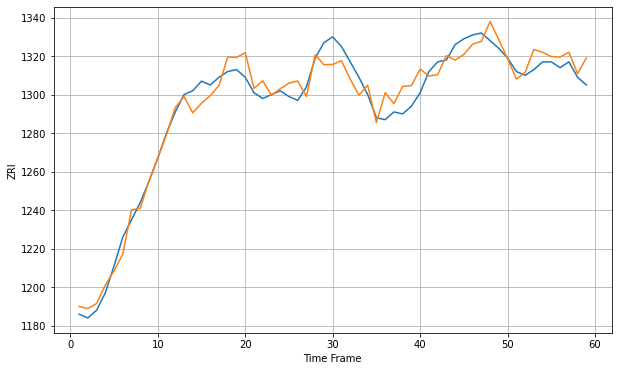

Wall time: 10.2 s
6610 7.338746527078018 6.682532719983937


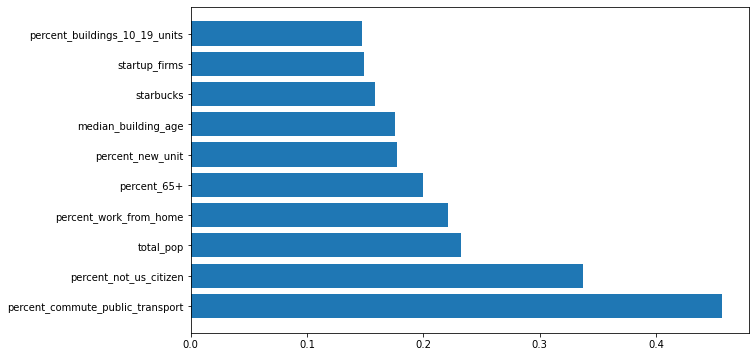


Got an mse at 0.0025 in epoch 75 and stopped training



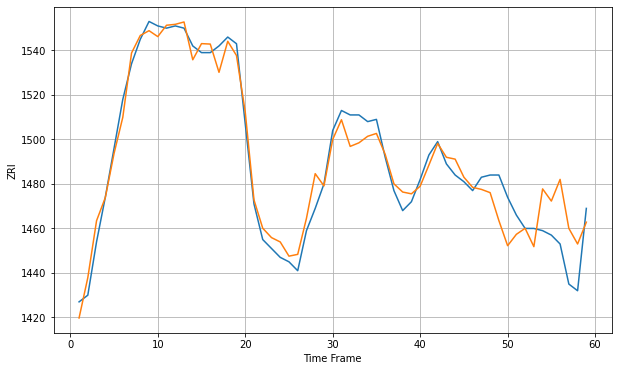

Wall time: 9.62 s
6614 6.10313226786346 17.398396016899014


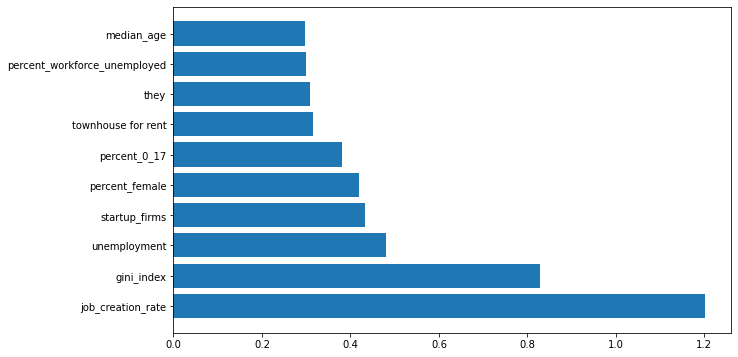


Got an mse at 0.0025 in epoch 154 and stopped training



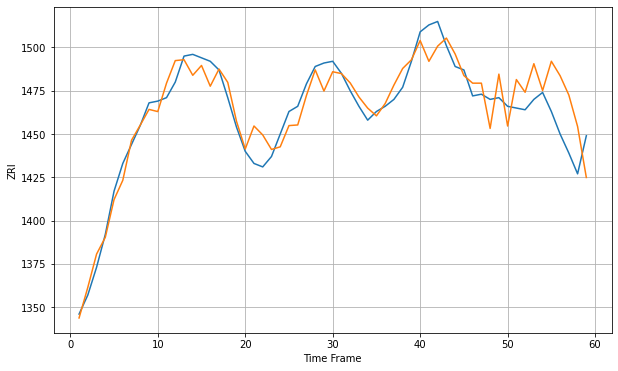

Wall time: 12.1 s
6615 8.633341098799027 22.024835508713508


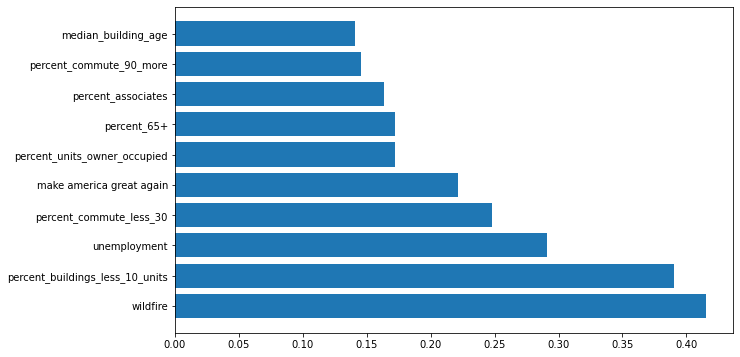


Got an mse at 0.0024 in epoch 39 and stopped training



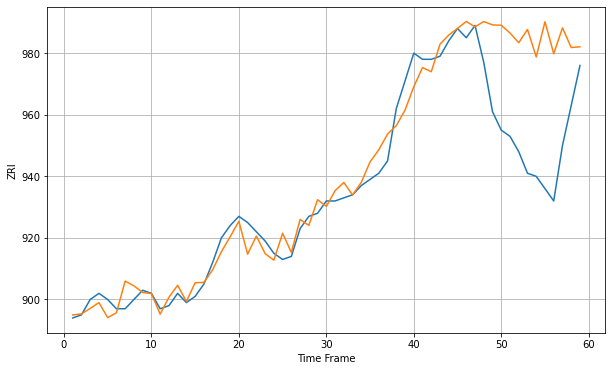

Wall time: 8.68 s
6704 4.595004829906476 35.66745411614077


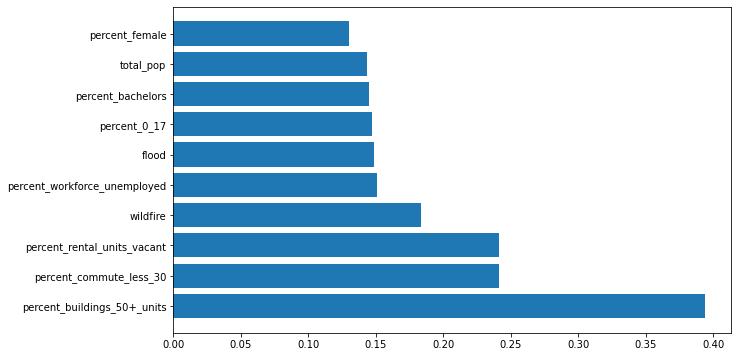


Got an mse at 0.0025 in epoch 58 and stopped training



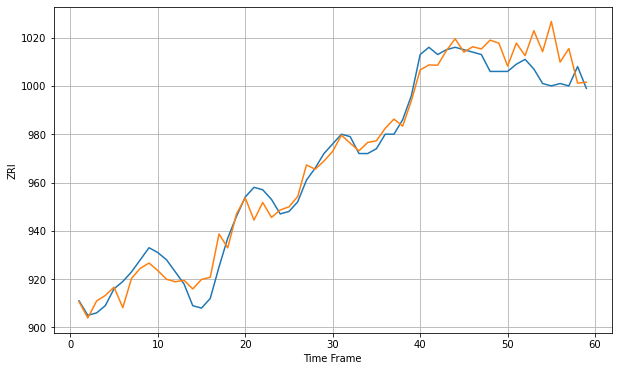

Wall time: 9.22 s
6705 5.463644734237662 12.57475325121547


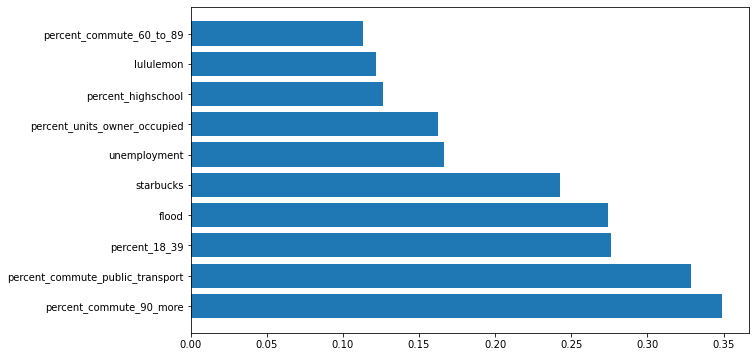


Got an mse at 0.0024 in epoch 33 and stopped training



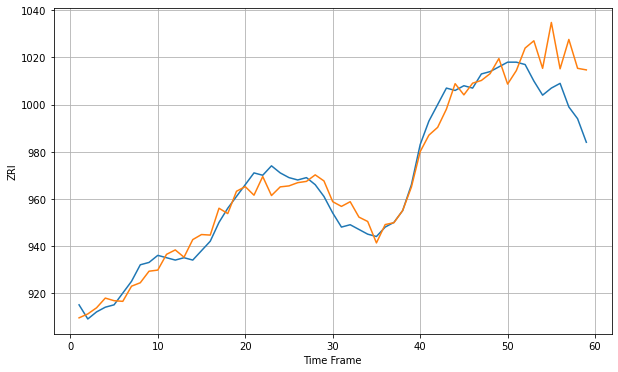

Wall time: 8.45 s
6708 5.169913658985073 17.36283490761174


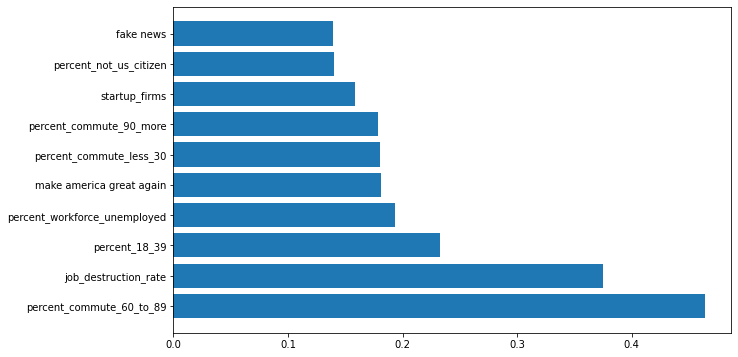


Got an mse at 0.0025 in epoch 87 and stopped training



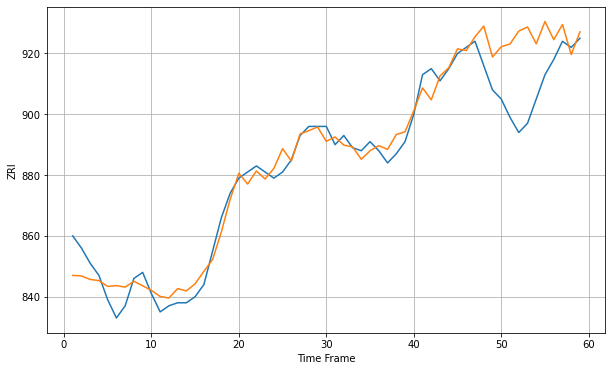

Wall time: 9.98 s
6710 4.56222716668808 18.259414700583402


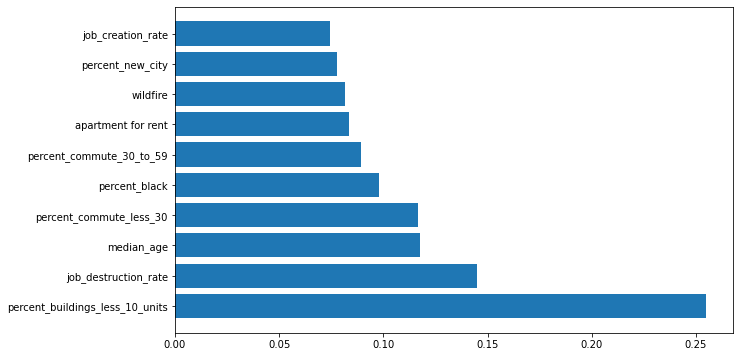


Got an mse at 0.0025 in epoch 97 and stopped training



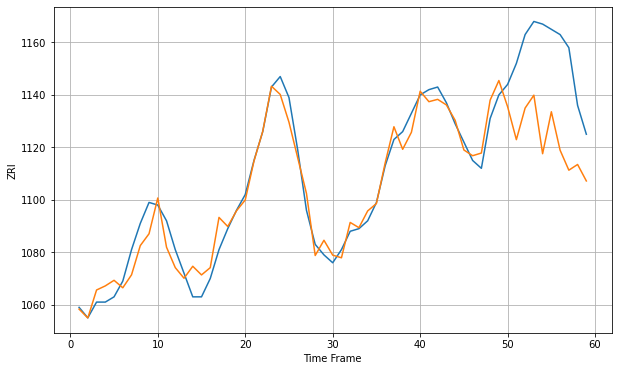

Wall time: 10.4 s
6770 5.546654492173656 30.20871039519501


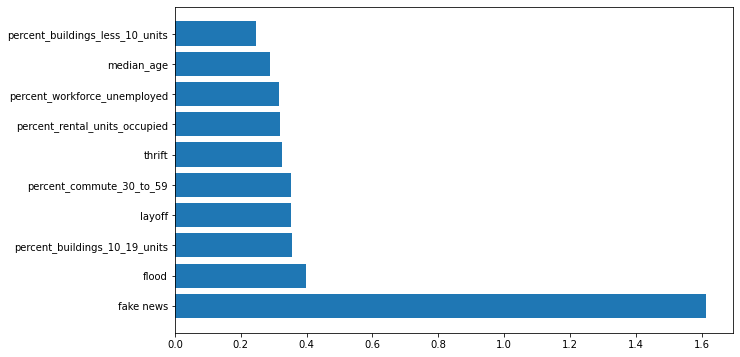


Got an mse at 0.0025 in epoch 50 and stopped training



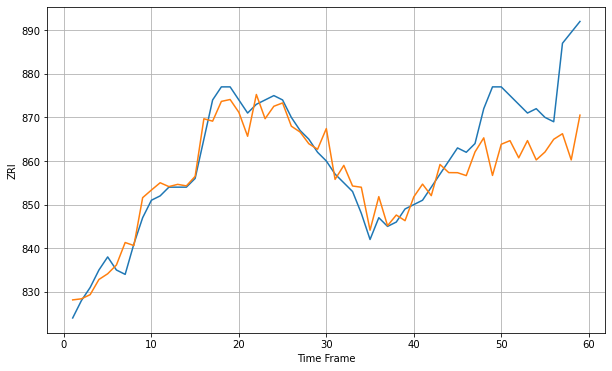

Wall time: 8.84 s
6790 3.3044484230909976 15.525852813438876


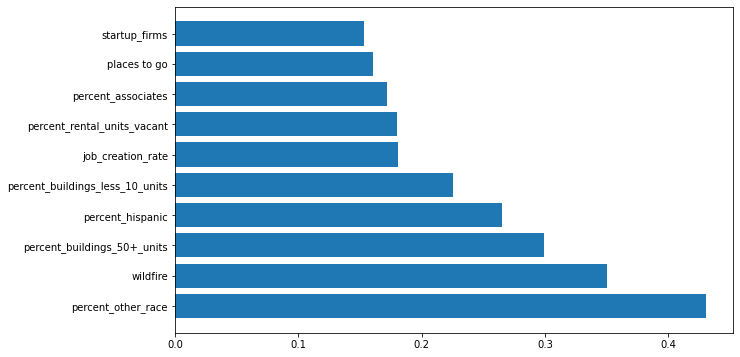


Got an mse at 0.0025 in epoch 102 and stopped training



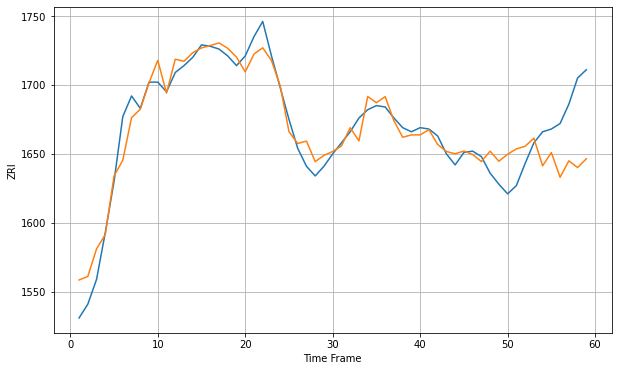

Wall time: 10.6 s
6810 10.613462459479708 35.02086900531198


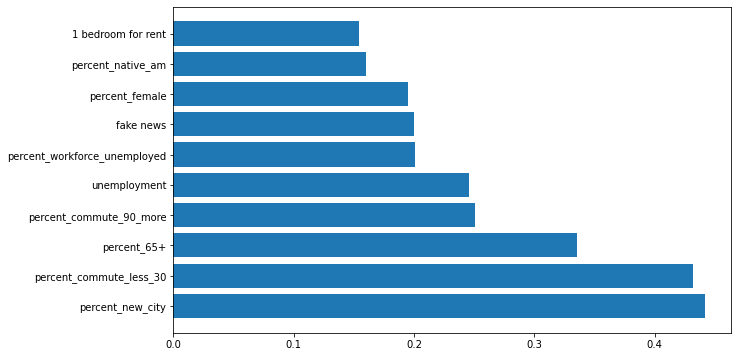


Got an mse at 0.0025 in epoch 97 and stopped training



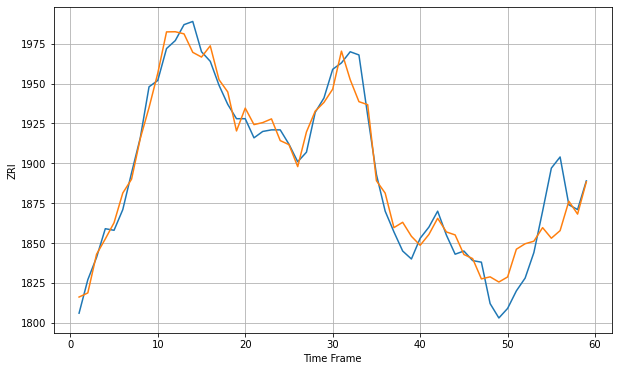

Wall time: 10.4 s
6824 9.43132771641277 23.395241194777203


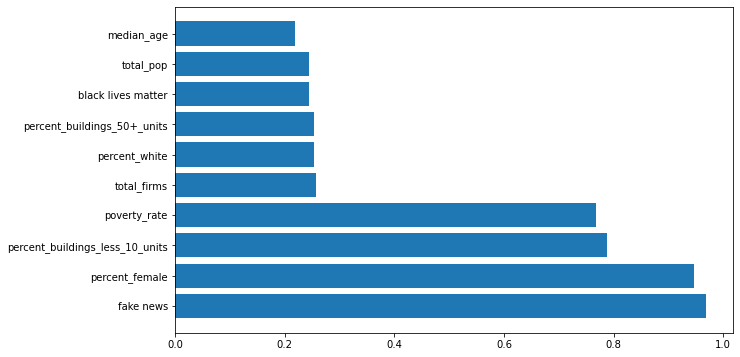


Got an mse at 0.0024 in epoch 128 and stopped training



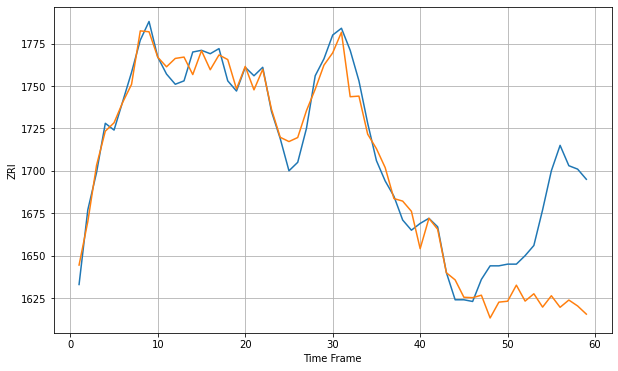

Wall time: 11.2 s
6825 9.002726918687742 58.059701896434994


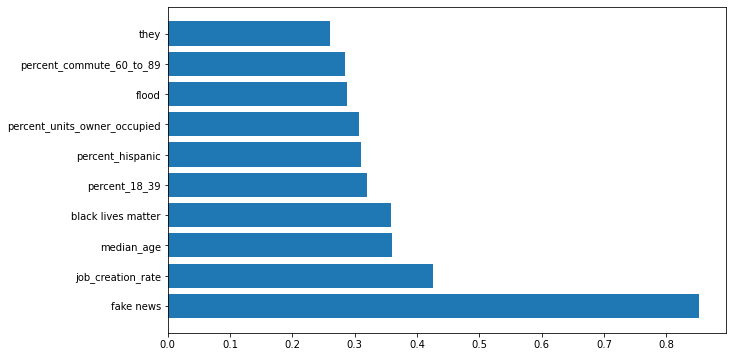


Got an mse at 0.0025 in epoch 95 and stopped training



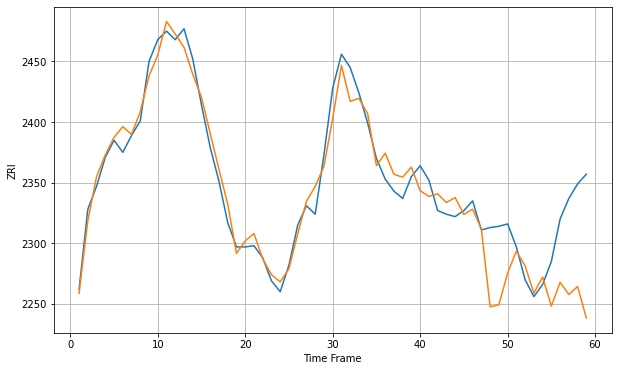

Wall time: 10.3 s
6830 11.95037776904435 59.08549839981275


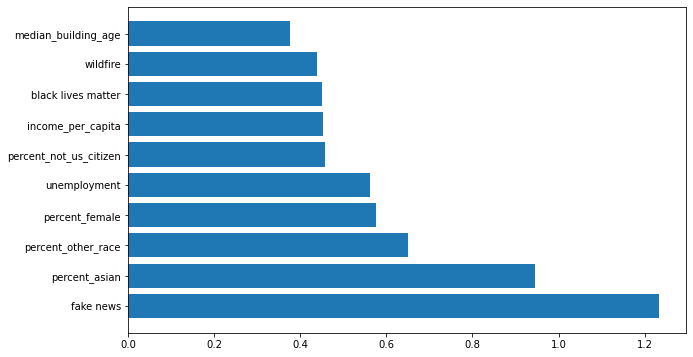


Got an mse at 0.0024 in epoch 78 and stopped training



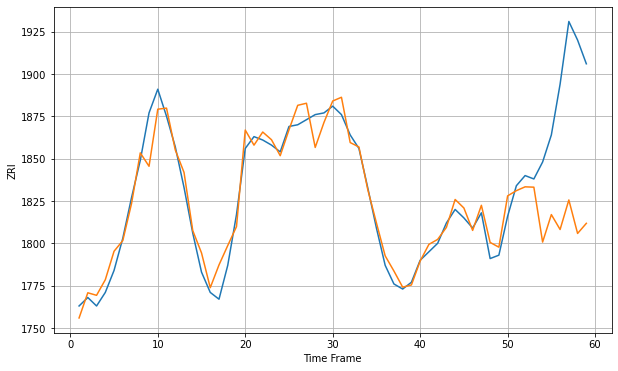

Wall time: 9.75 s
6851 8.591046198821866 61.34995702851423


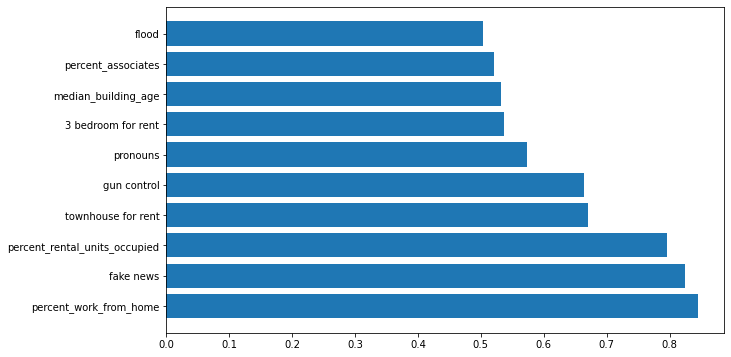


Got an mse at 0.0025 in epoch 134 and stopped training



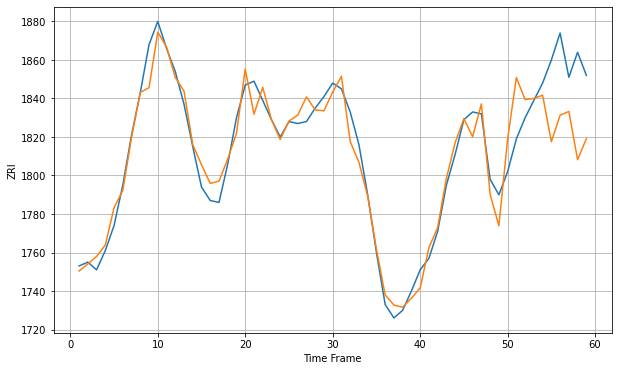

Wall time: 11.3 s
6854 7.502614342984675 28.70888522123921


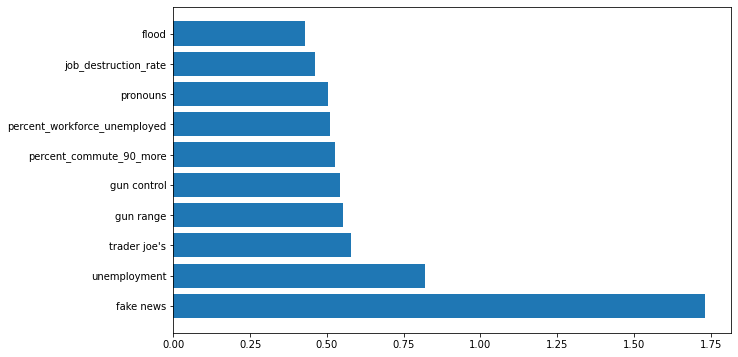


Got an mse at 0.0025 in epoch 210 and stopped training



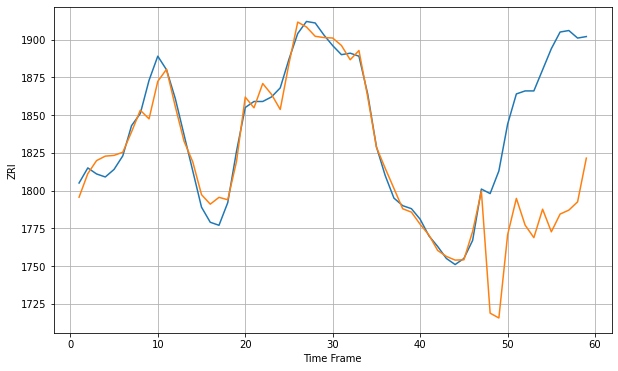

Wall time: 13.7 s
6855 7.879270330321565 97.22862332795452


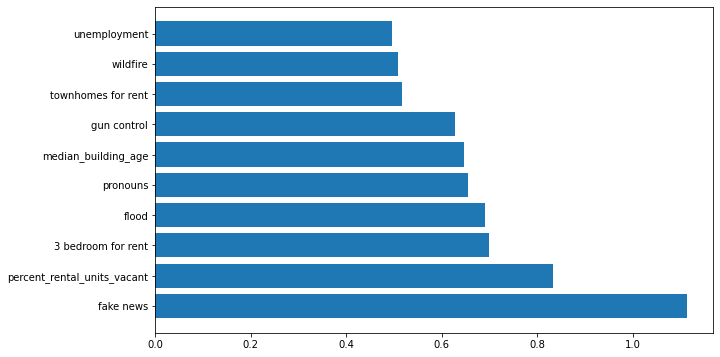


Got an mse at 0.0024 in epoch 107 and stopped training



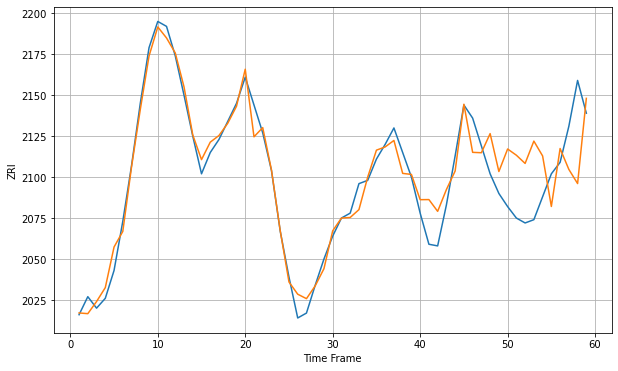

Wall time: 10.5 s
6902 9.017762447718132 32.83395814331418


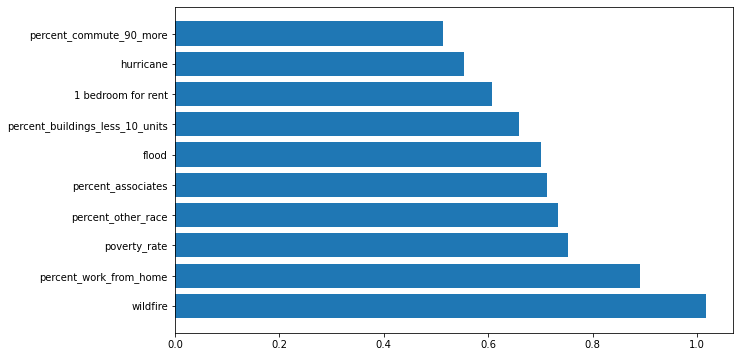


Got an mse at 0.0024 in epoch 111 and stopped training



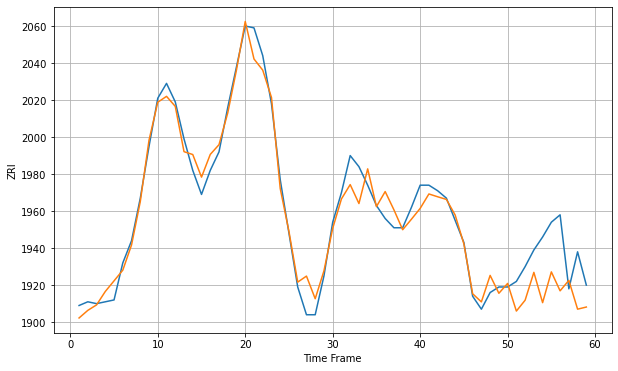

Wall time: 10.8 s
6906 7.757671906438949 21.641960526300842


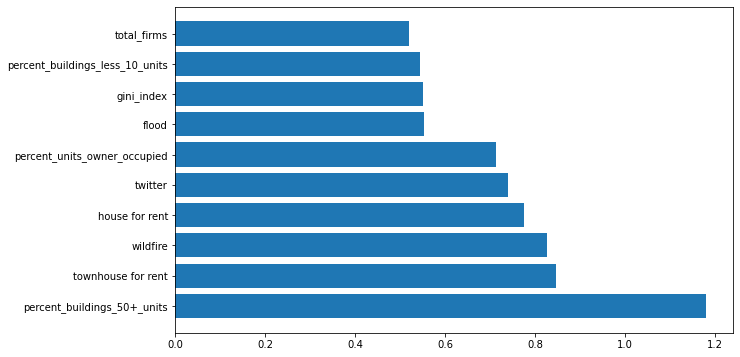


Got an mse at 0.0025 in epoch 54 and stopped training



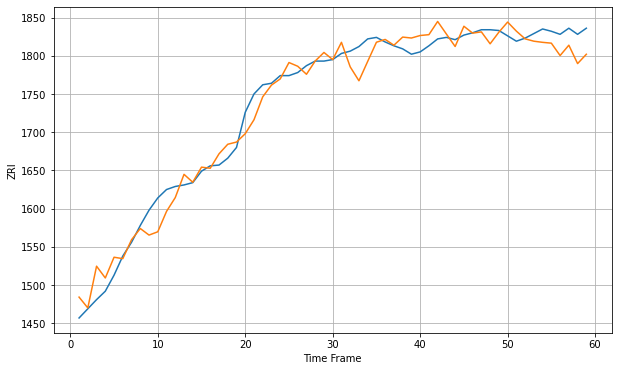

Wall time: 9.01 s
7002 18.964512788340816 21.17799246526351


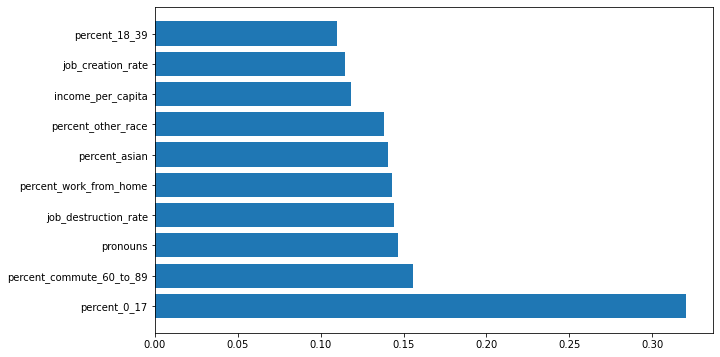


Got an mse at 0.0025 in epoch 42 and stopped training



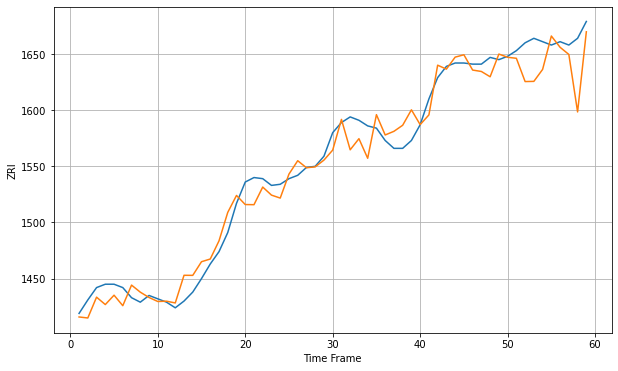

Wall time: 8.71 s
7003 13.40159740257447 26.11556923170013


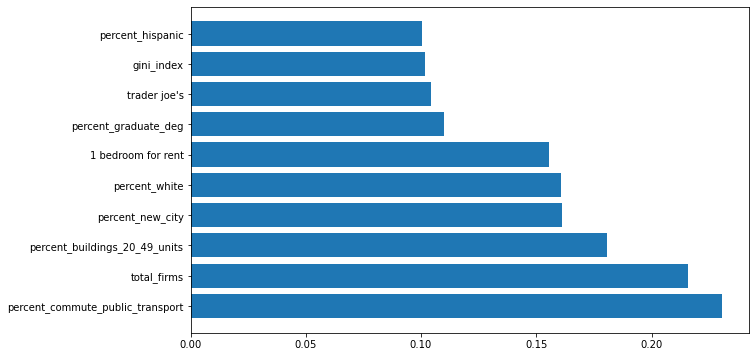


Got an mse at 0.0025 in epoch 43 and stopped training



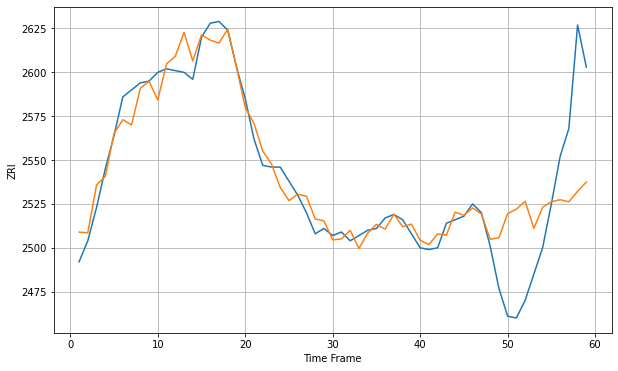

Wall time: 8.81 s
7030 8.313281959582149 48.428220755559536


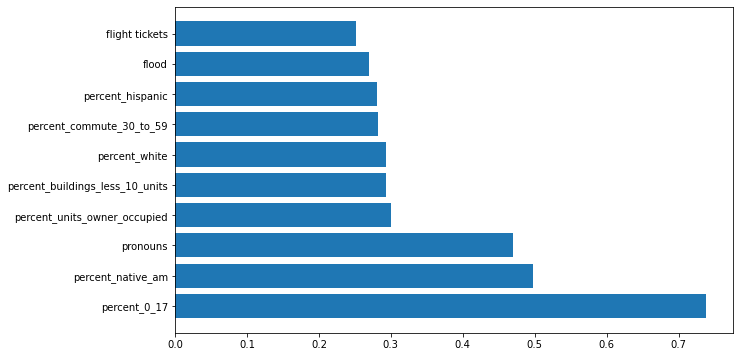


Got an mse at 0.0024 in epoch 35 and stopped training



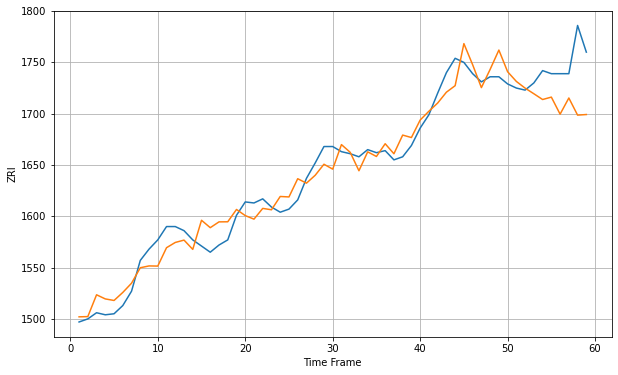

Wall time: 8.77 s
7055 14.309283221712736 36.28136018400514


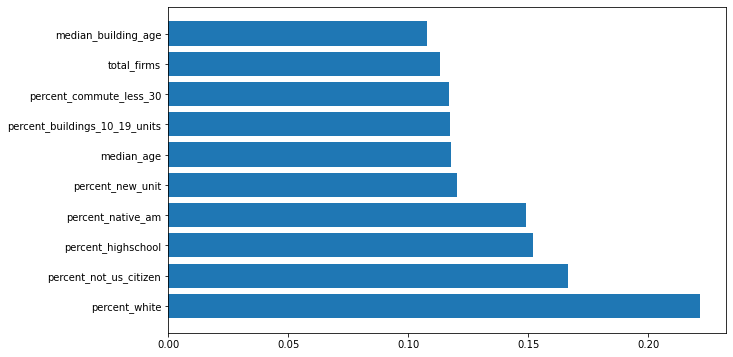


Got an mse at 0.0025 in epoch 57 and stopped training



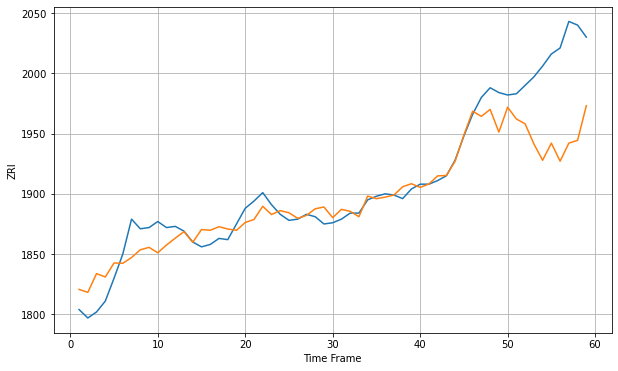

Wall time: 9.06 s
7093 12.06175970873921 63.9064335419726


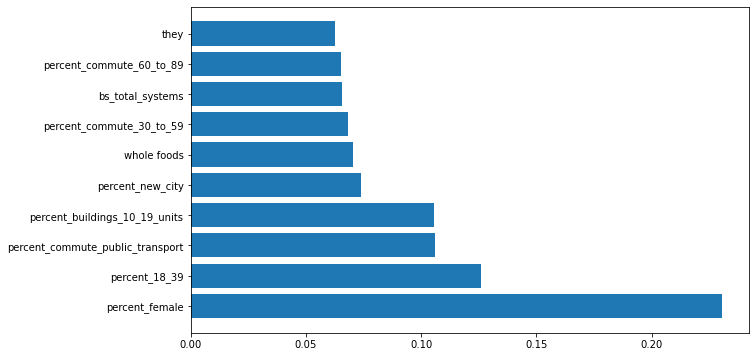


Got an mse at 0.0024 in epoch 28 and stopped training



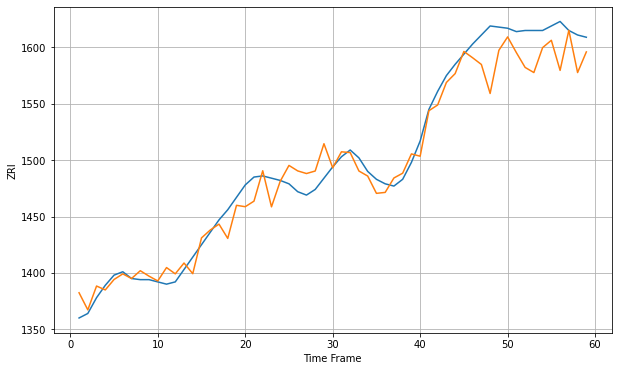

Wall time: 8.37 s
7109 12.604369972649893 29.490339264673924


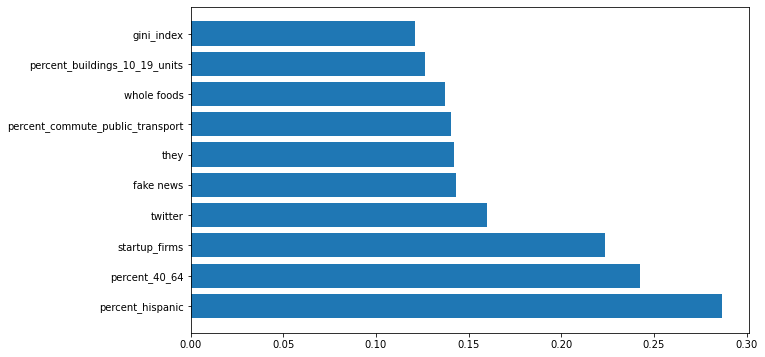


Got an mse at 0.0023 in epoch 26 and stopped training



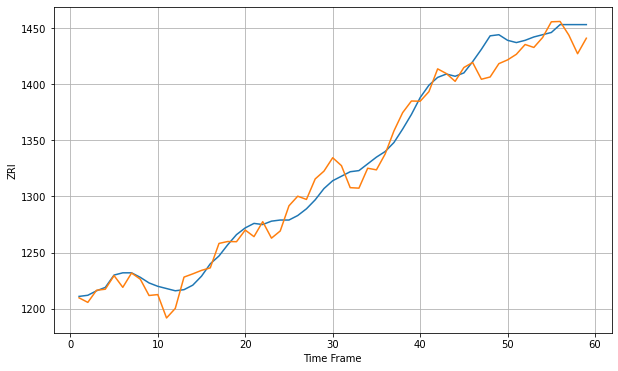

Wall time: 8.3 s
7111 11.082424992402546 17.147657150552


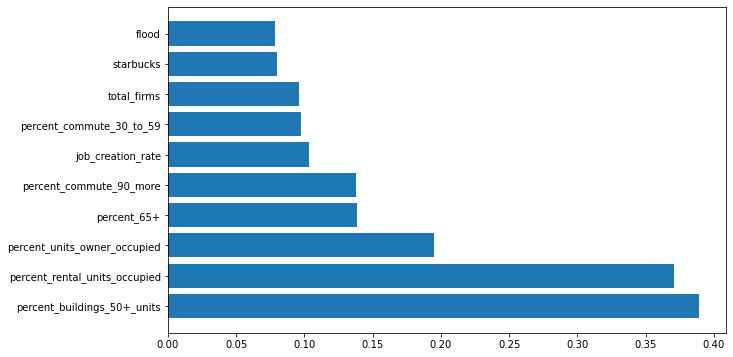


Got an mse at 0.0024 in epoch 73 and stopped training



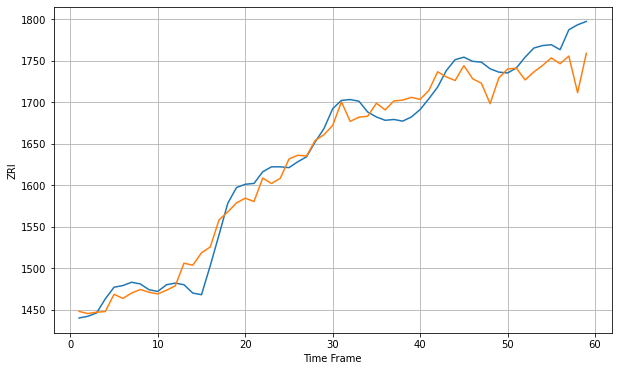

Wall time: 9.47 s
7201 17.41798473697358 33.750907452493266


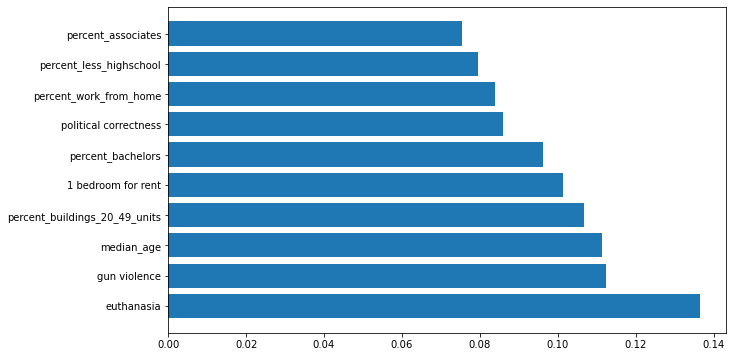


Got an mse at 0.0024 in epoch 40 and stopped training



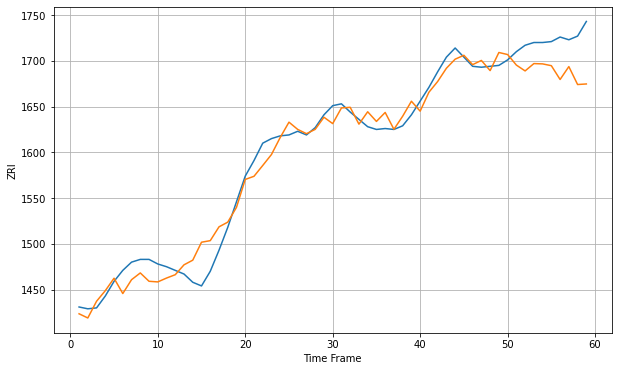

Wall time: 8.81 s
7202 15.233457858548379 33.54215290352304


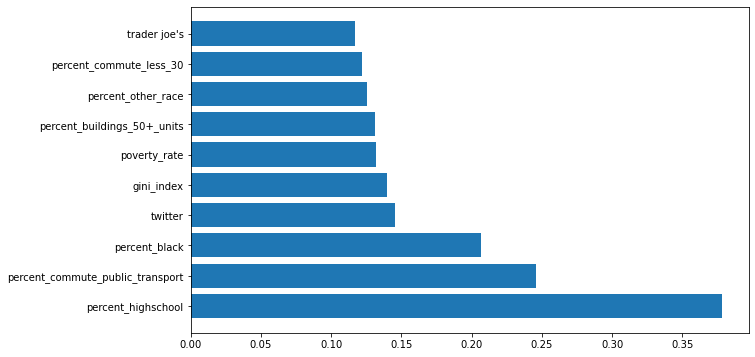


Got an mse at 0.0024 in epoch 32 and stopped training



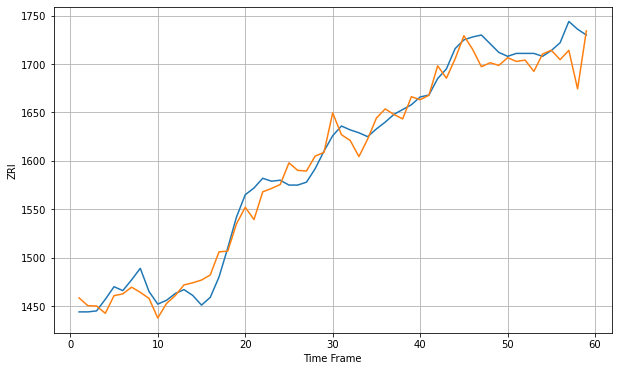

Wall time: 8.4 s
7206 14.364107007997209 22.438158062425835


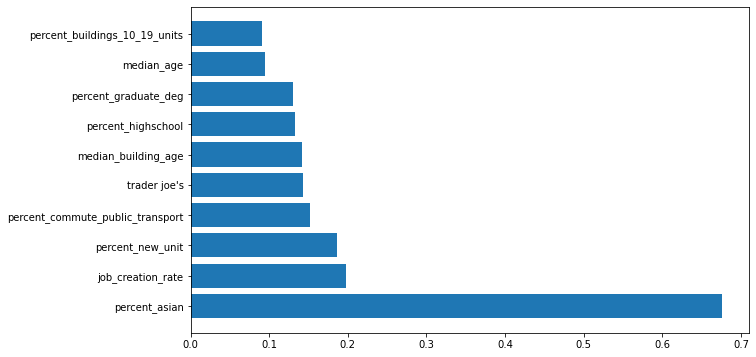


Got an mse at 0.0025 in epoch 52 and stopped training



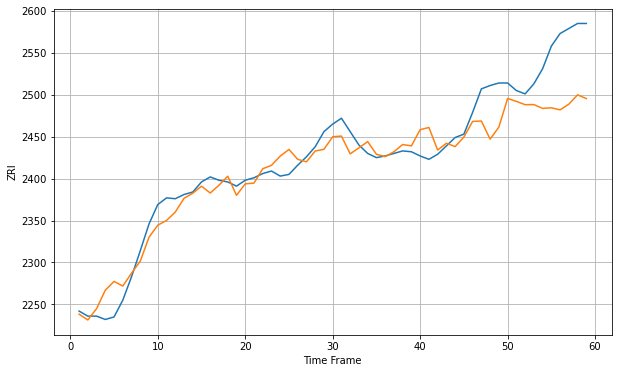

Wall time: 8.83 s
7302 17.307028590660494 62.90819305652156


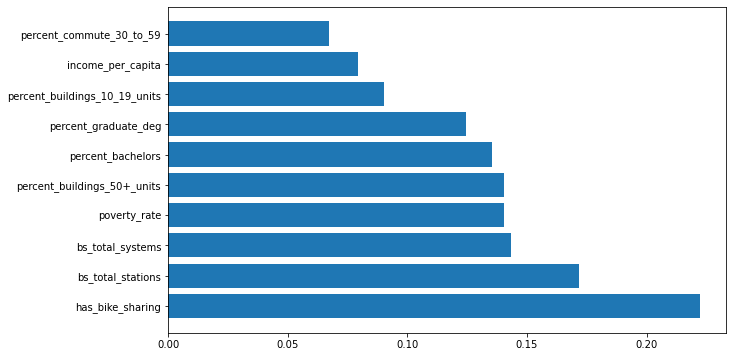


Got an mse at 0.0025 in epoch 56 and stopped training



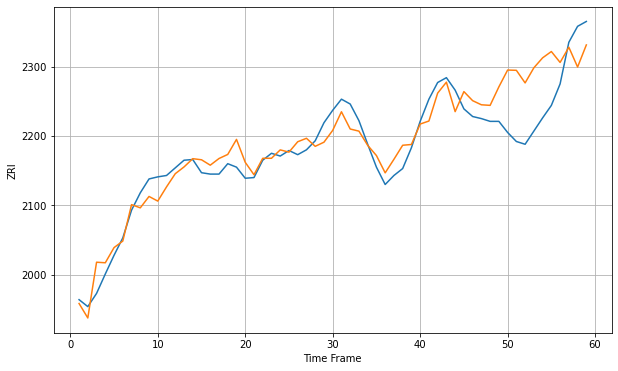

Wall time: 9.04 s
7960 20.233238605869488 68.85459023519293


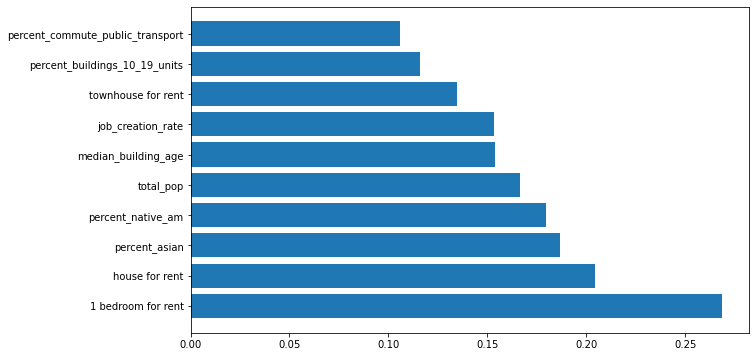


Got an mse at 0.0025 in epoch 70 and stopped training



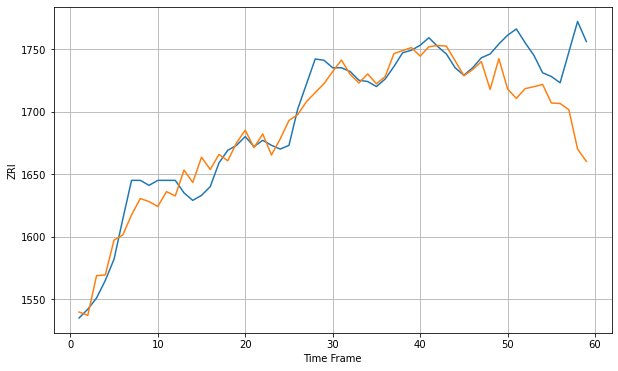

Wall time: 9.61 s
8901 11.898921547014504 50.30720345524372


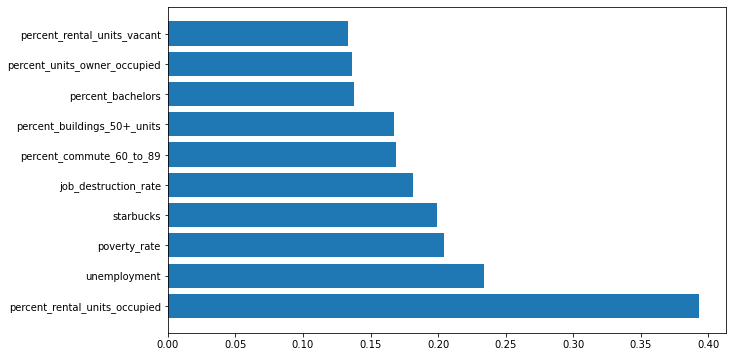


Got an mse at 0.0025 in epoch 86 and stopped training



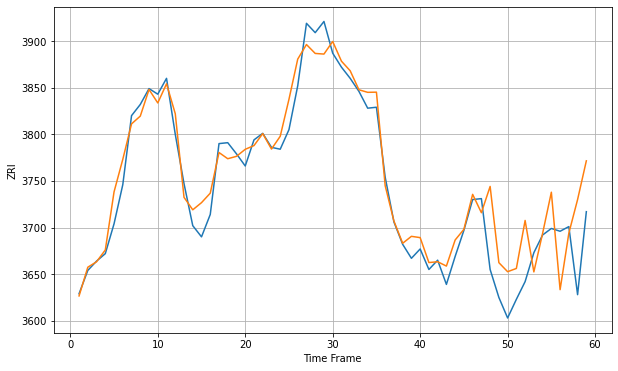

Wall time: 10.1 s
10001 16.531144757532285 55.13609219724199


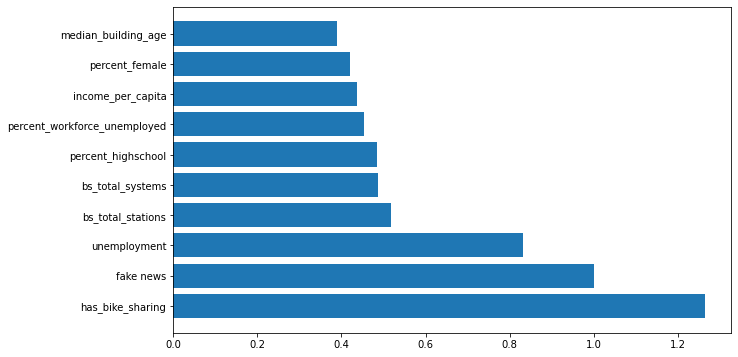


Got an mse at 0.0025 in epoch 218 and stopped training



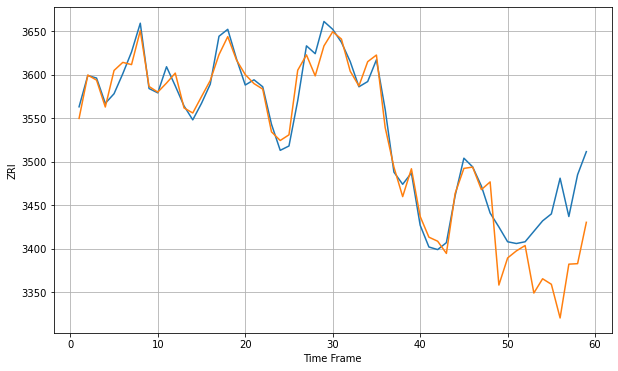

Wall time: 13.8 s
10002 12.992202834985394 75.22895876109342


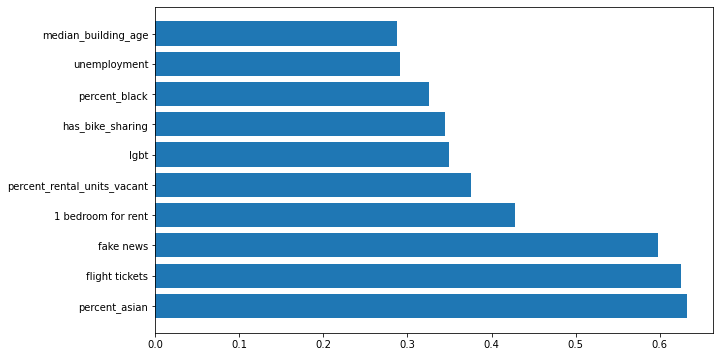


Got an mse at 0.0025 in epoch 131 and stopped training



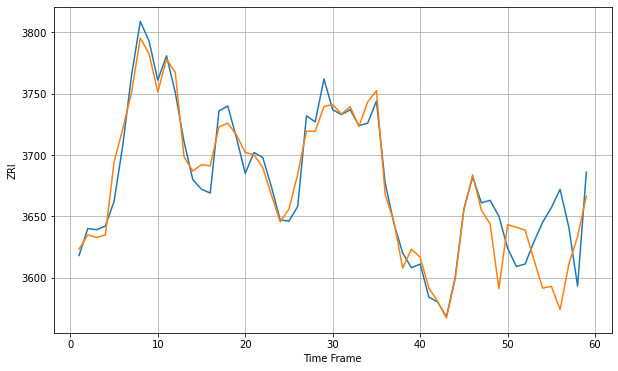

Wall time: 11.2 s
10003 11.85916475774738 46.353102449804375


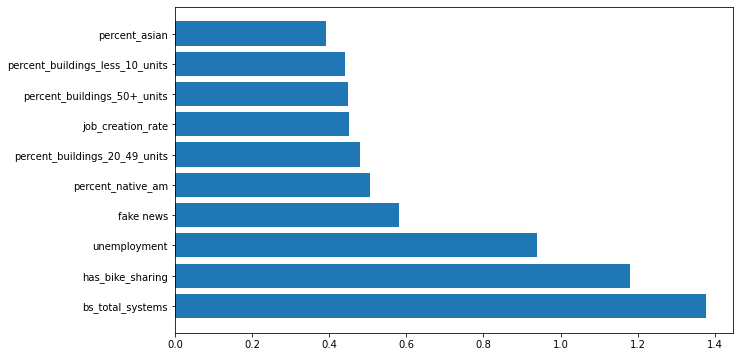


Got an mse at 0.0024 in epoch 62 and stopped training



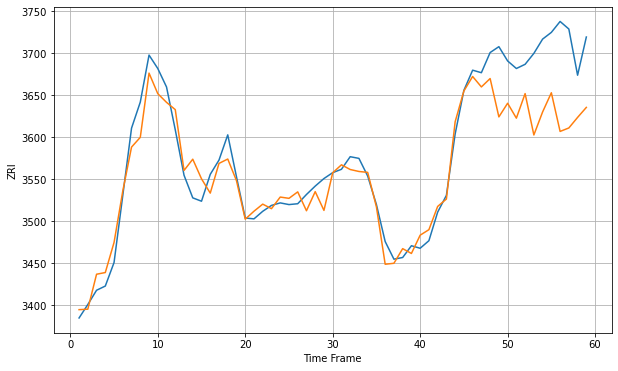

Wall time: 9.27 s
10005 17.84431613684008 80.55690314174701


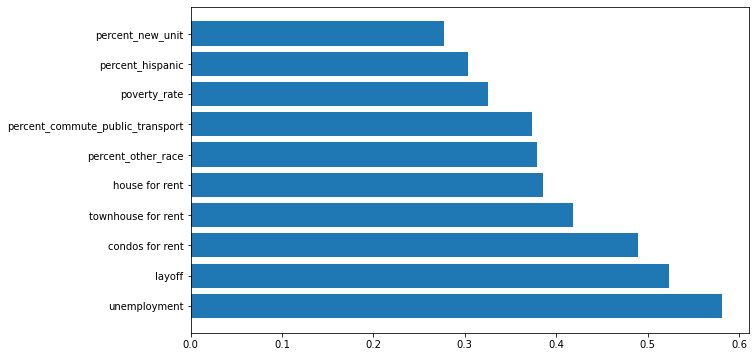


Got an mse at 0.0024 in epoch 90 and stopped training



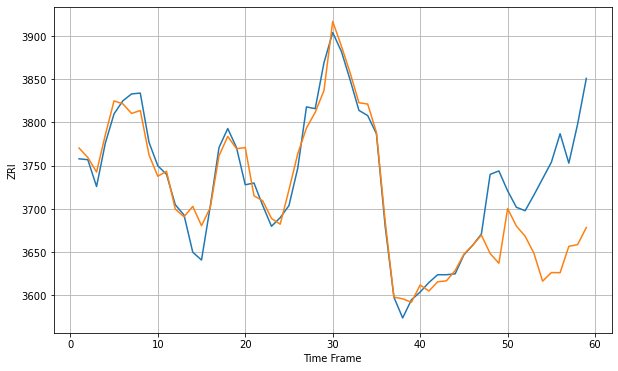

Wall time: 10.3 s
10009 16.30652024362899 108.18256746342408


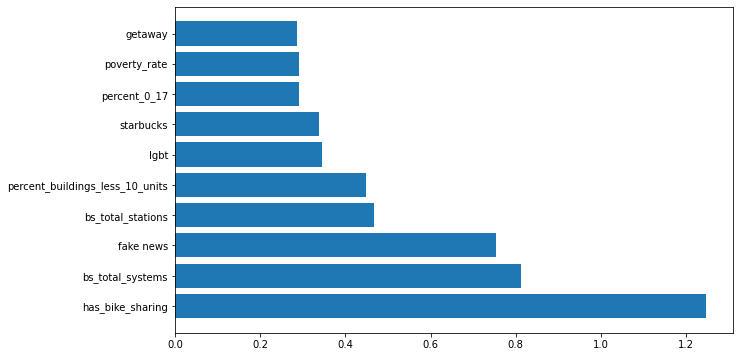


Got an mse at 0.0025 in epoch 181 and stopped training



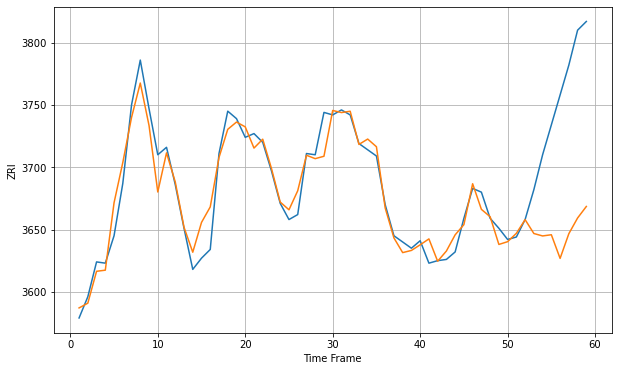

Wall time: 12.7 s
10010 13.131659007129008 88.38573600778437


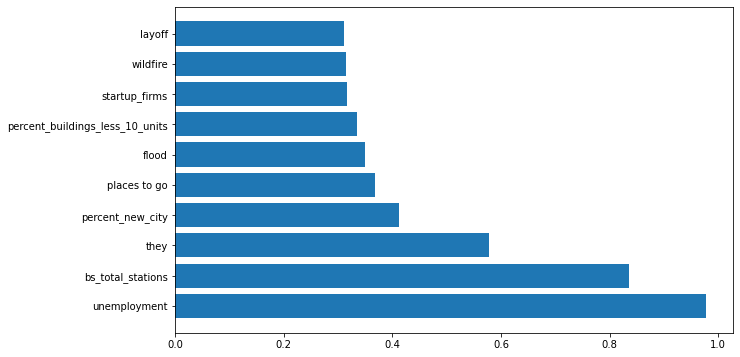


Got an mse at 0.0025 in epoch 107 and stopped training



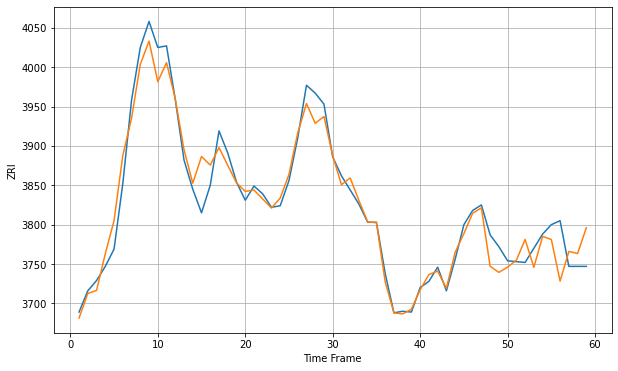

Wall time: 11.5 s
10011 19.14979445218804 33.47764547807109


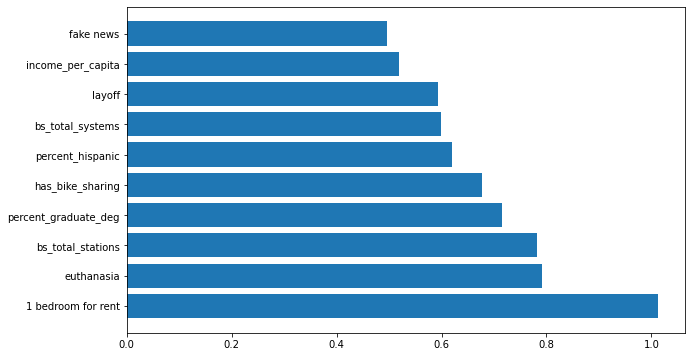


Got an mse at 0.0024 in epoch 182 and stopped training



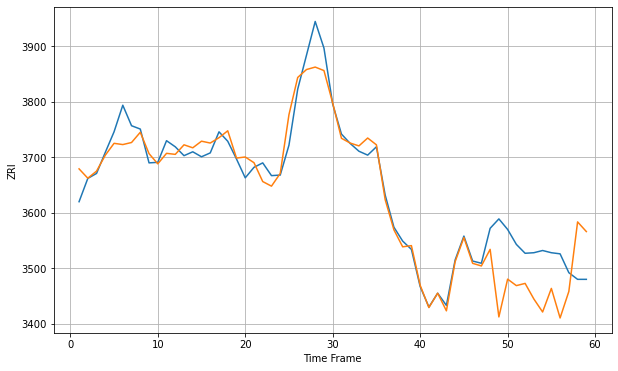

Wall time: 13.5 s
10012 25.275048582032863 93.65247690555118


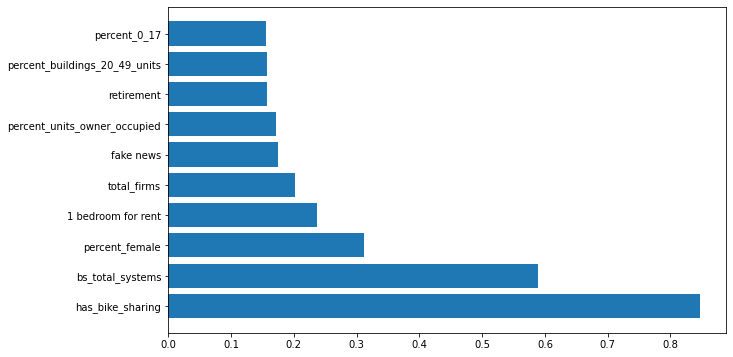


Got an mse at 0.0025 in epoch 102 and stopped training



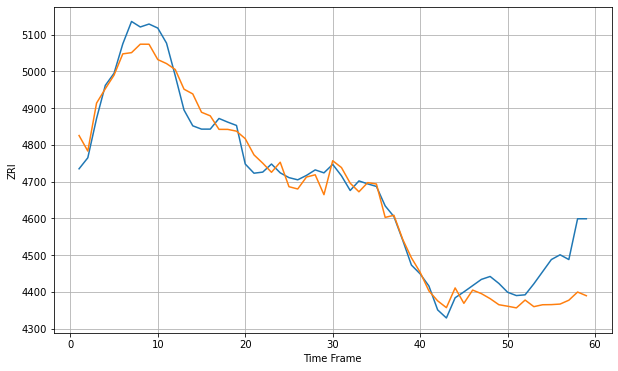

Wall time: 12.3 s
10013 39.2293824011547 112.04569922052974


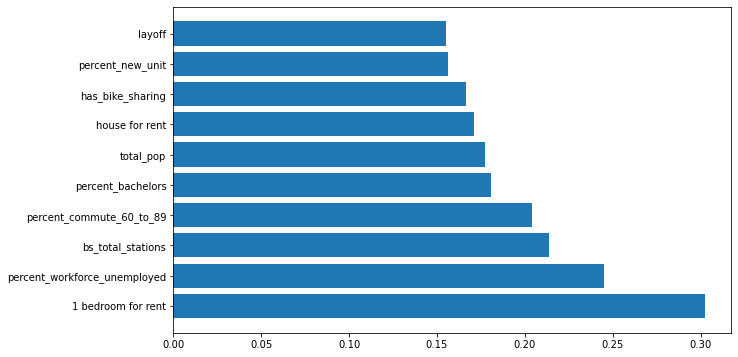


Got an mse at 0.0025 in epoch 135 and stopped training



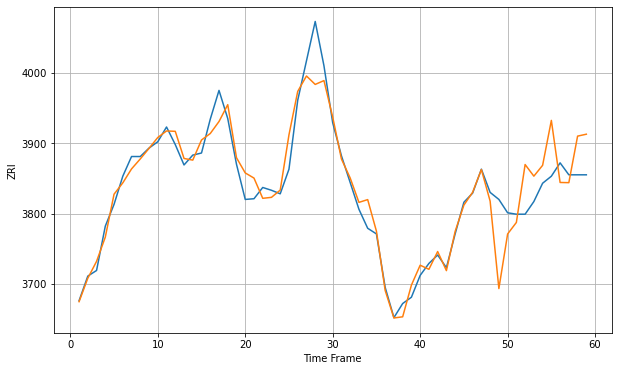

Wall time: 12 s
10014 21.546510020258967 56.08674048865004


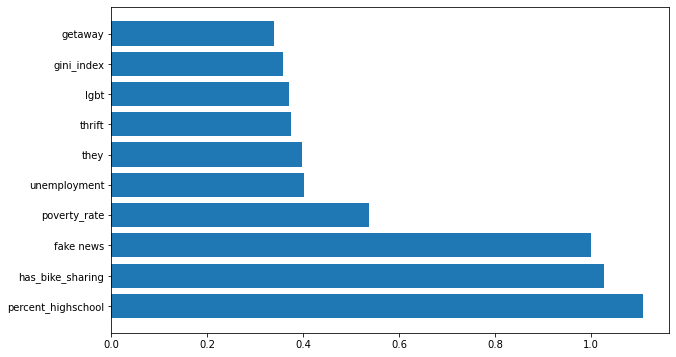


Got an mse at 0.0024 in epoch 74 and stopped training



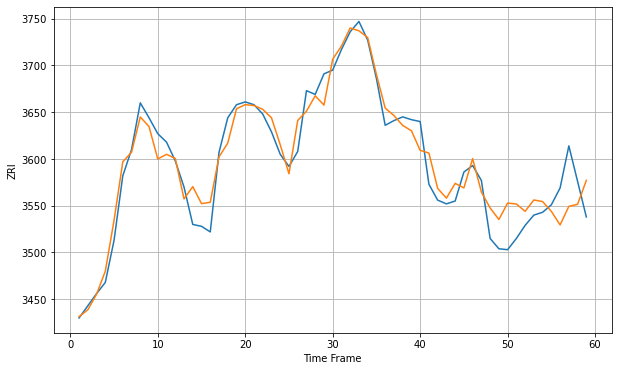

Wall time: 10 s
10016 16.857041923766364 34.66884173665267


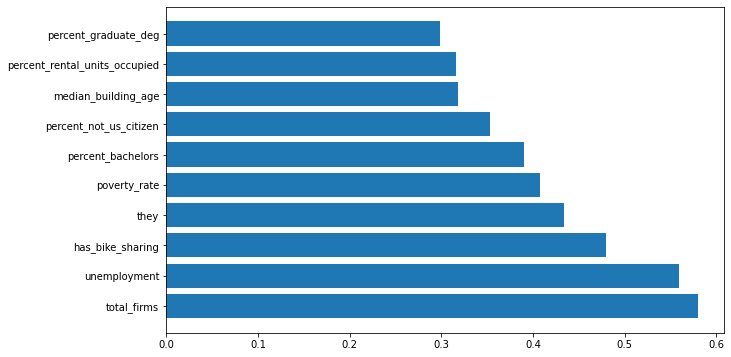


Got an mse at 0.0024 in epoch 99 and stopped training



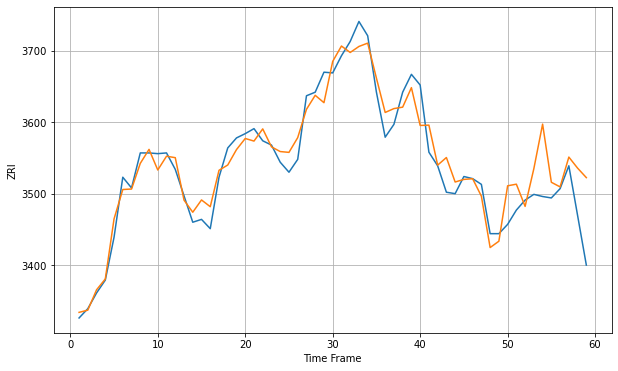

Wall time: 11 s
10017 21.69429889323895 55.05809226972666


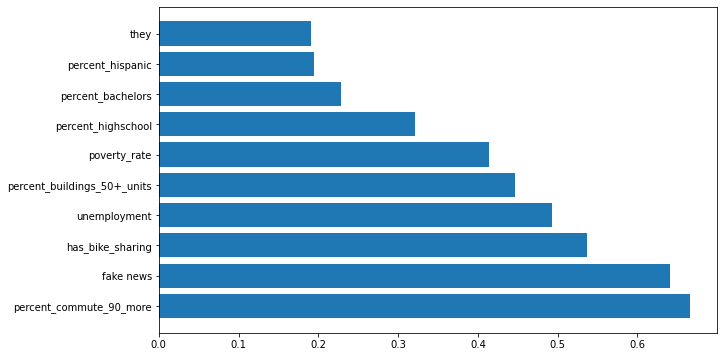


Got an mse at 0.0025 in epoch 145 and stopped training



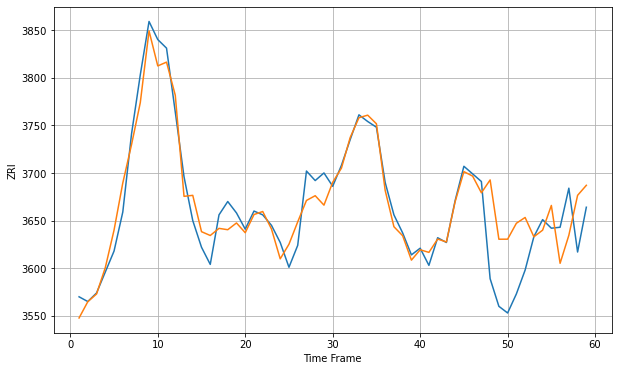

Wall time: 12.4 s
10018 16.25663308386146 56.9393648146508


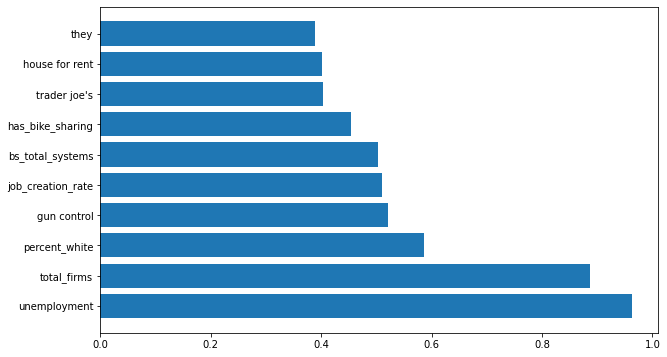


Got an mse at 0.0025 in epoch 116 and stopped training



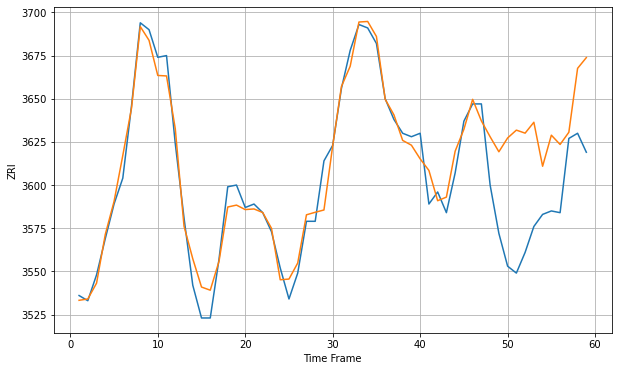

Wall time: 11.7 s
10019 9.144171172718261 52.04760693673587


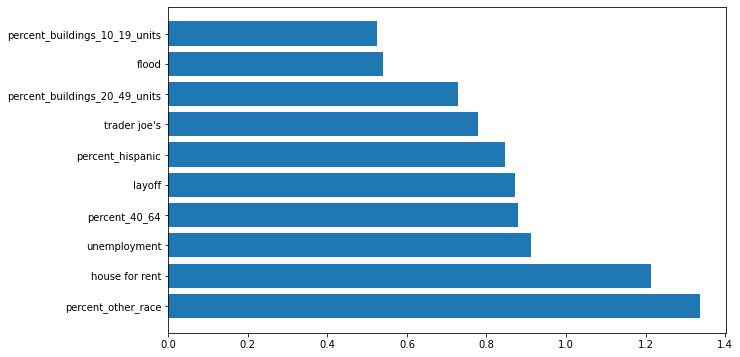


Got an mse at 0.0025 in epoch 95 and stopped training



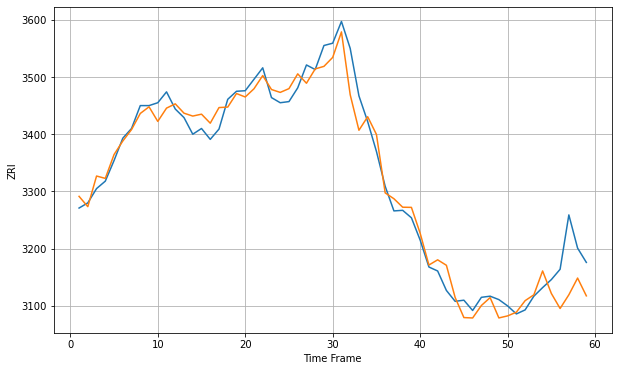

Wall time: 10.9 s
10021 24.72555280316284 52.74258049944578


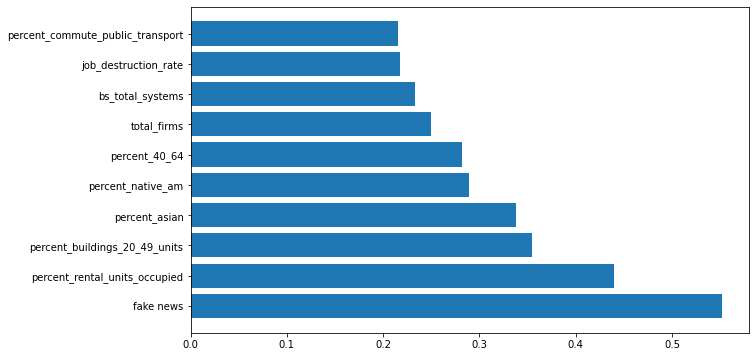


Got an mse at 0.0024 in epoch 135 and stopped training



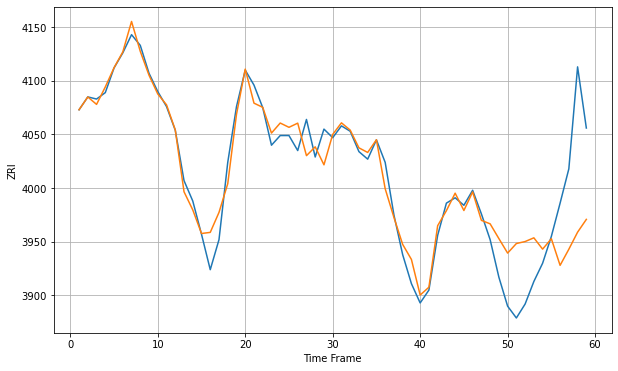

Wall time: 11.7 s
10022 12.939588983654644 67.04864165973724


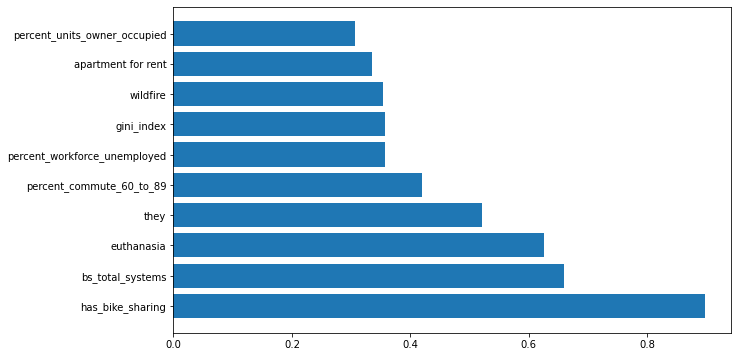


Got an mse at 0.0025 in epoch 135 and stopped training



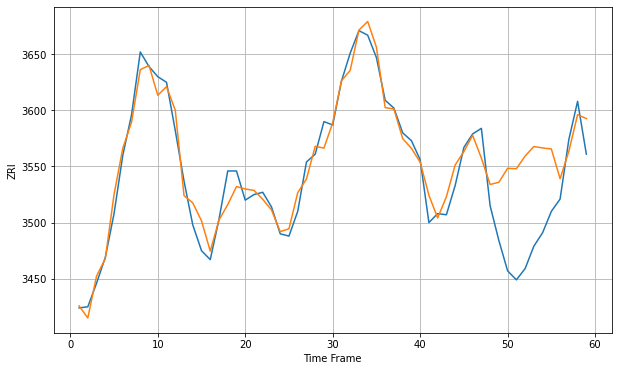

Wall time: 11.8 s
10023 12.741329425438355 64.24318156836549


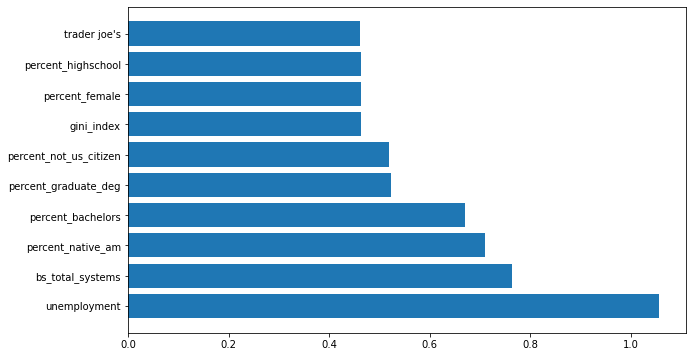


Got an mse at 0.0024 in epoch 106 and stopped training



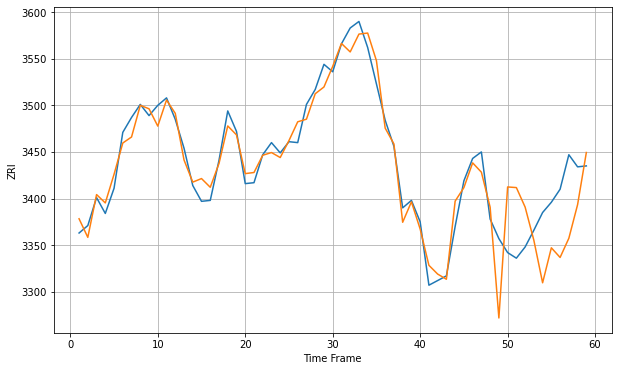

Wall time: 11 s
10024 13.71279537867656 60.13152728776201


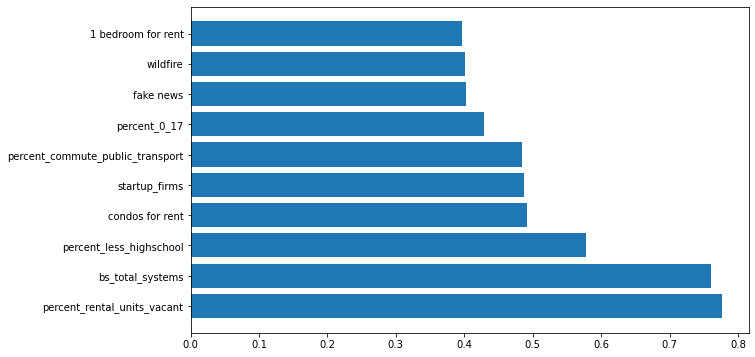


Got an mse at 0.0024 in epoch 144 and stopped training



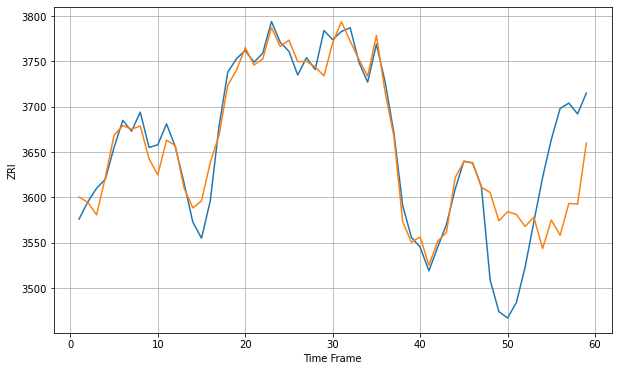

Wall time: 12.2 s
10025 16.07300848822074 92.80112082630704


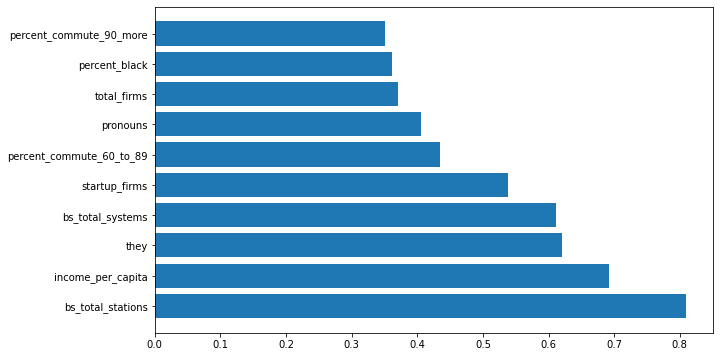


Got an mse at 0.0025 in epoch 113 and stopped training



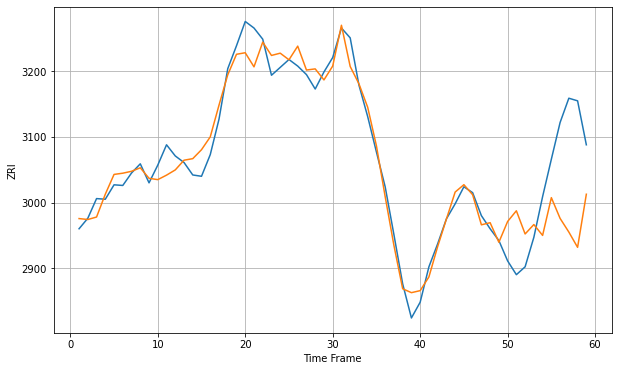

Wall time: 11.1 s
10027 22.293054372737487 108.61375158098805


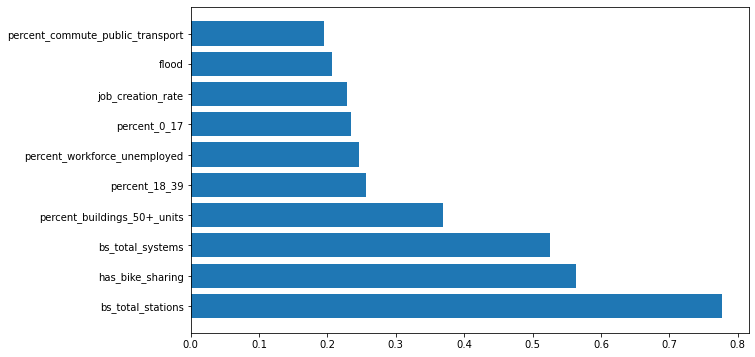


Got an mse at 0.0025 in epoch 93 and stopped training



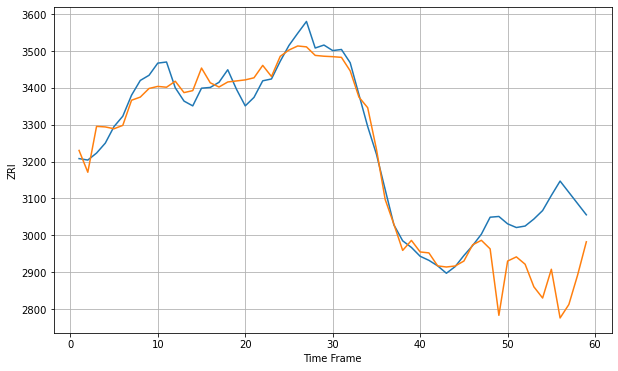

Wall time: 10.4 s
10028 33.70997150998998 206.2269832548717


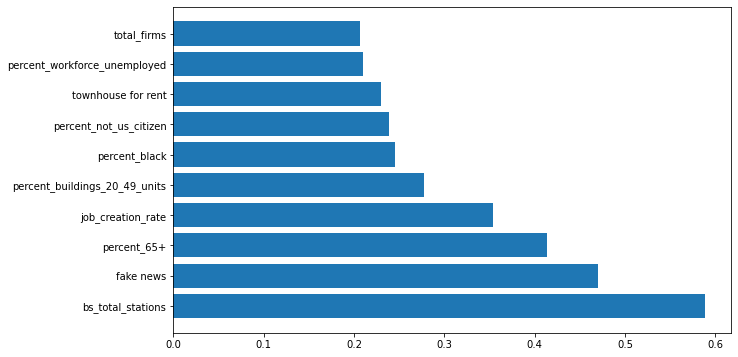


Got an mse at 0.0024 in epoch 97 and stopped training



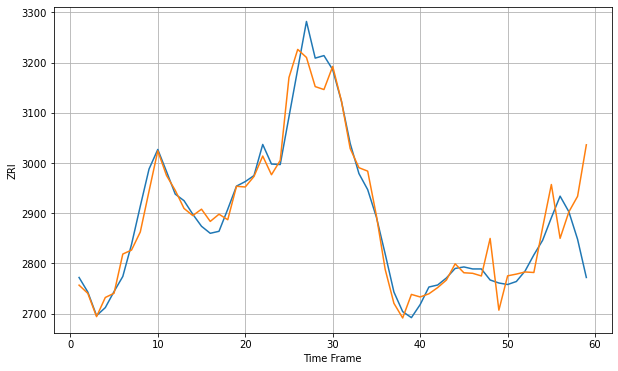

Wall time: 10.8 s
10029 28.877818266152204 91.65569381840025


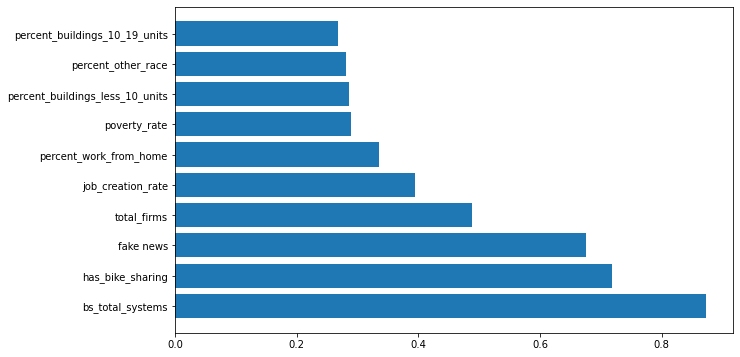


Got an mse at 0.0025 in epoch 148 and stopped training



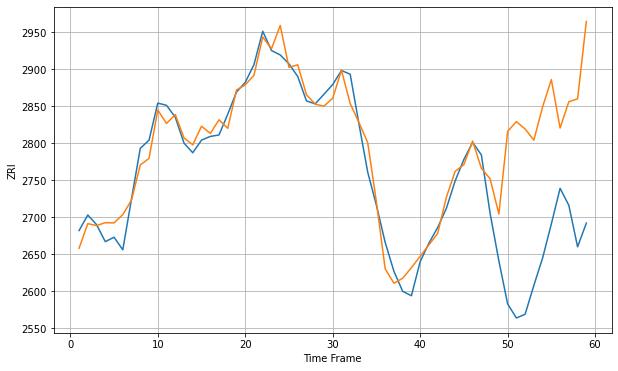

Wall time: 13.3 s
10031 19.174179106556526 193.94205586898548


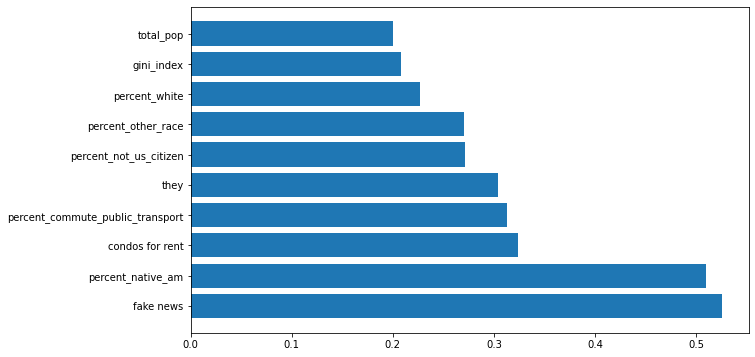


Got an mse at 0.0025 in epoch 155 and stopped training



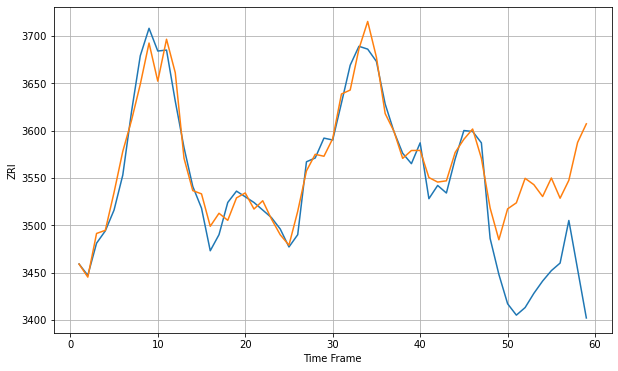

Wall time: 13.1 s
10036 15.118685837105664 108.91760270922168


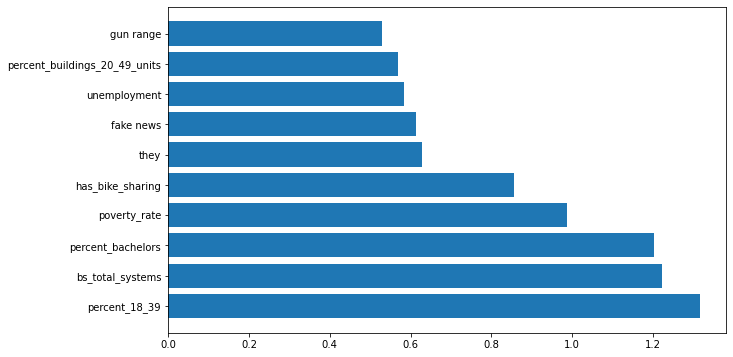


Got an mse at 0.0024 in epoch 132 and stopped training



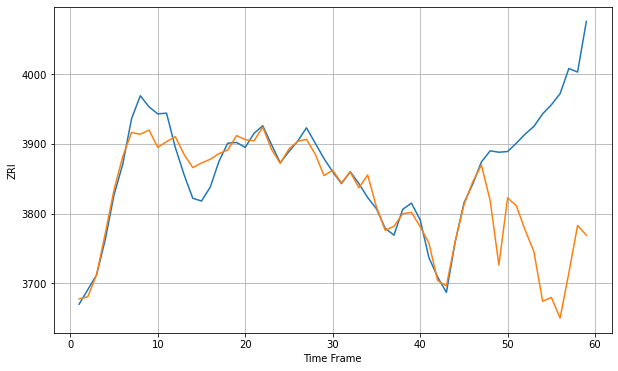

Wall time: 11.9 s
10038 20.831094963139034 218.89777374501574


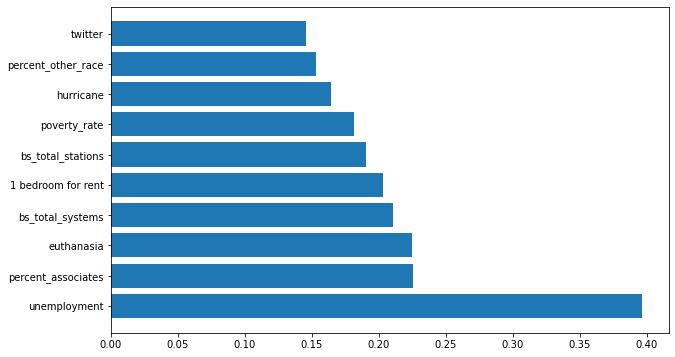


Got an mse at 0.0025 in epoch 52 and stopped training



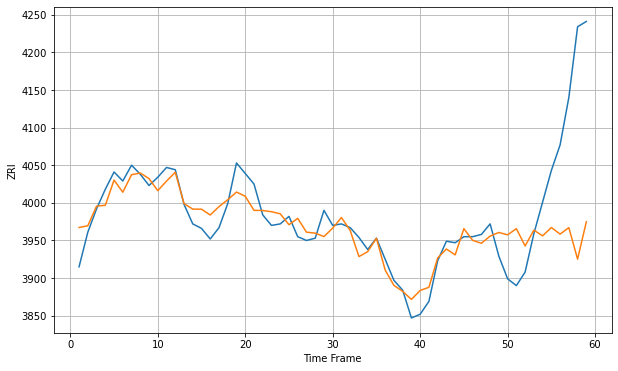

Wall time: 9.2 s
10065 19.16643252818028 138.31689478070936


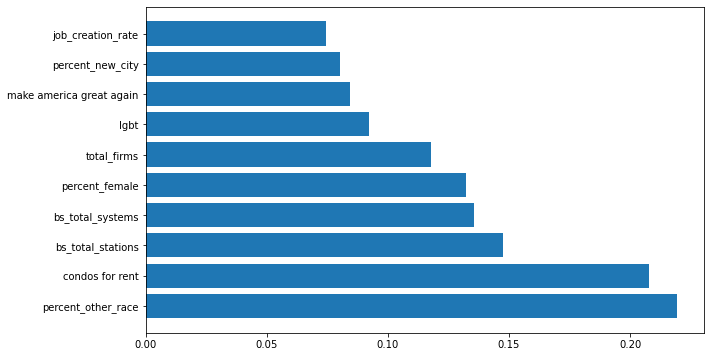


Got an mse at 0.0025 in epoch 128 and stopped training



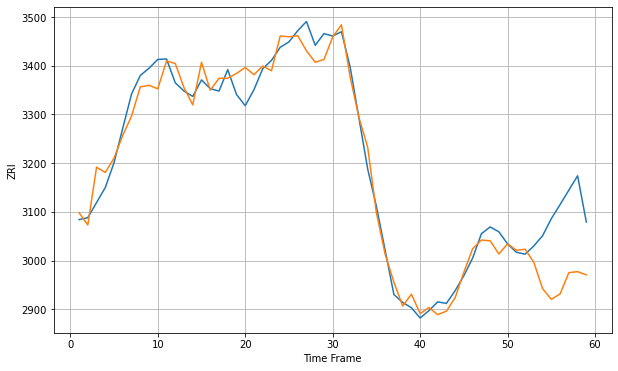

Wall time: 11.1 s
10075 30.158044724857852 114.14608101511602


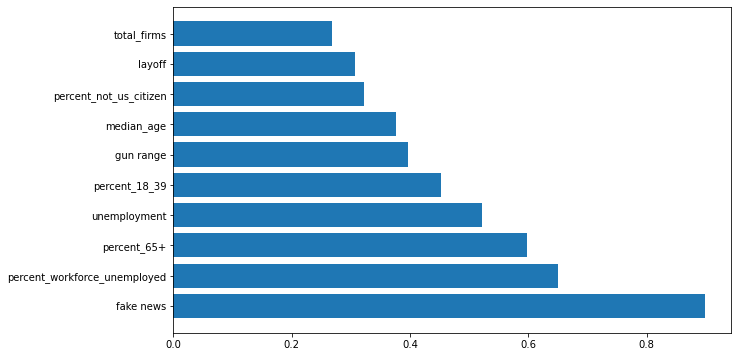


Got an mse at 0.0025 in epoch 128 and stopped training



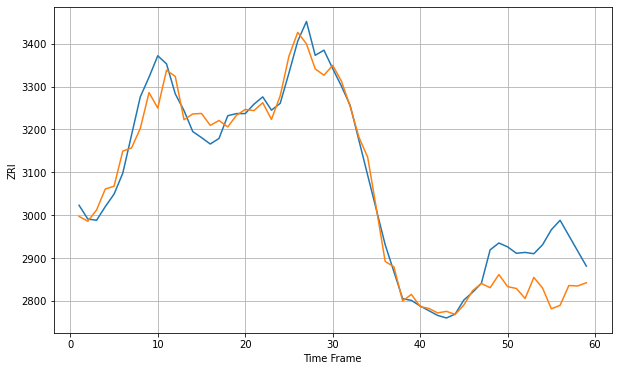

Wall time: 11.5 s
10128 34.145014660291196 111.36820287378531


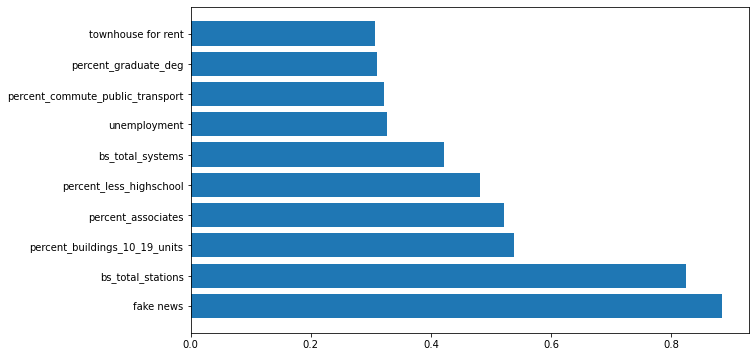


Got an mse at 0.0025 in epoch 136 and stopped training



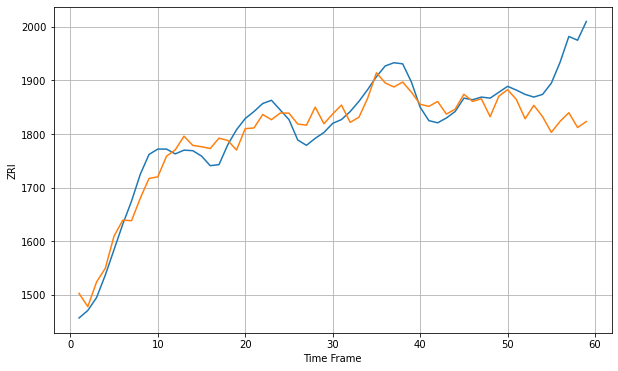

Wall time: 15.3 s
10302 28.037769790591497 94.75385087118055


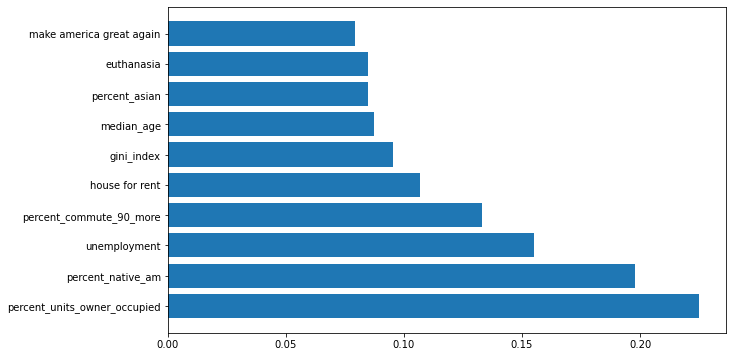

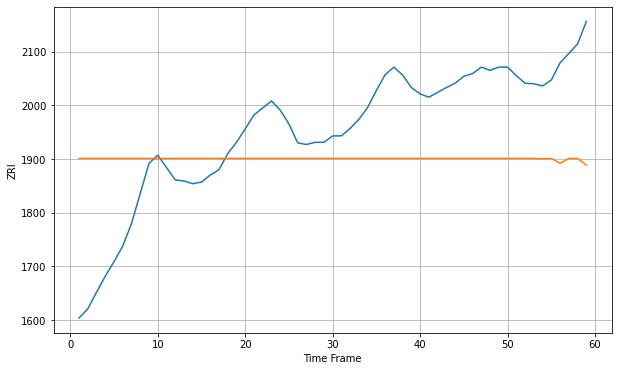

Wall time: 22.6 s
10303 122.30439567554984 177.23722896503224


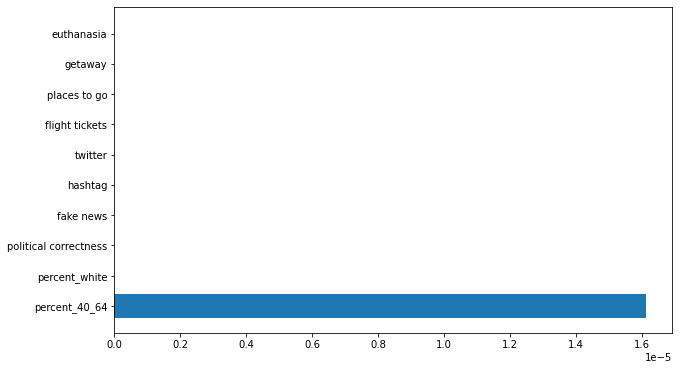


Got an mse at 0.0025 in epoch 108 and stopped training



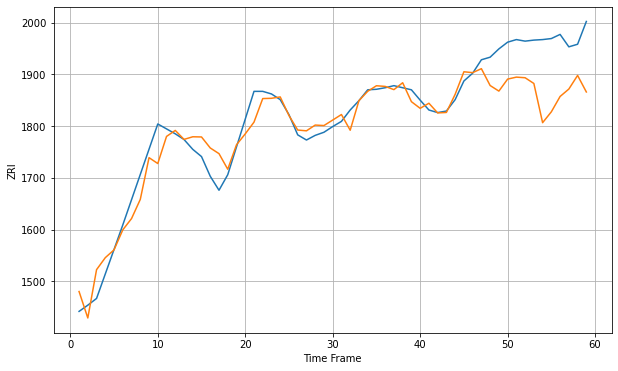

Wall time: 12.1 s
10304 27.58647139160228 100.40294277432064


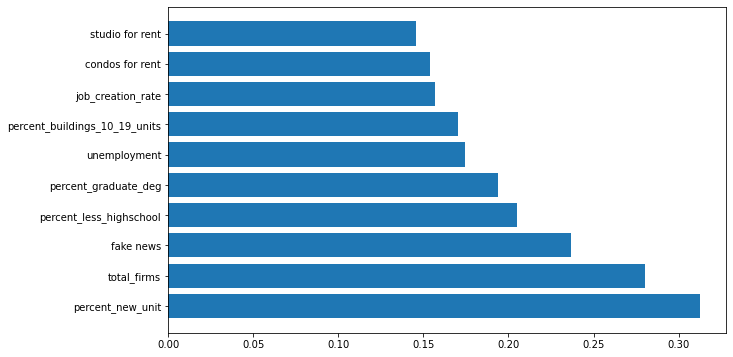


Got an mse at 0.0025 in epoch 55 and stopped training



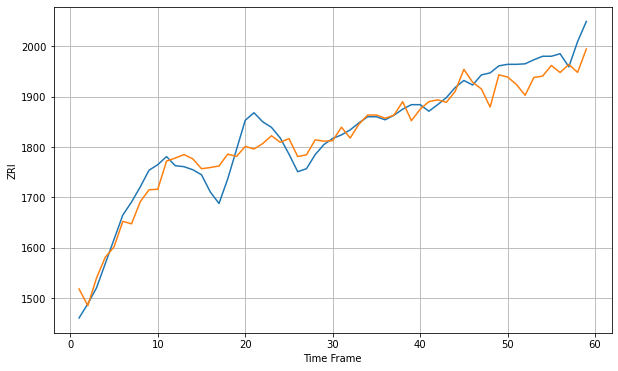

Wall time: 9.86 s
10305 29.218882819195716 43.036242138412256


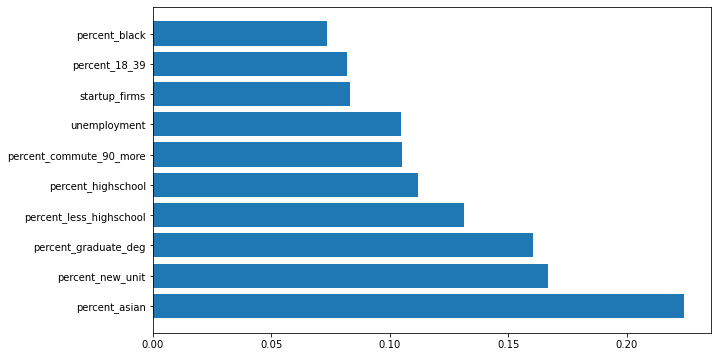


Got an mse at 0.0025 in epoch 125 and stopped training



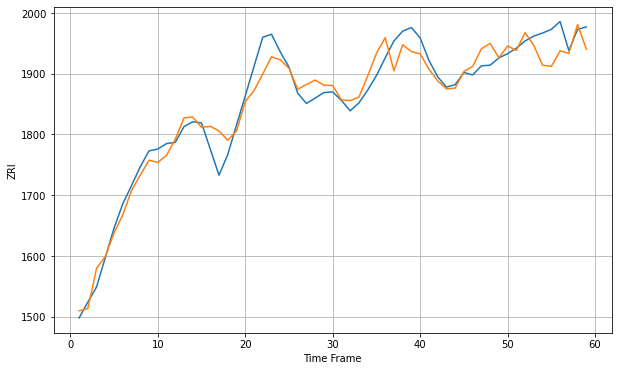

Wall time: 11.6 s
10306 25.05156079033787 31.850192654517276


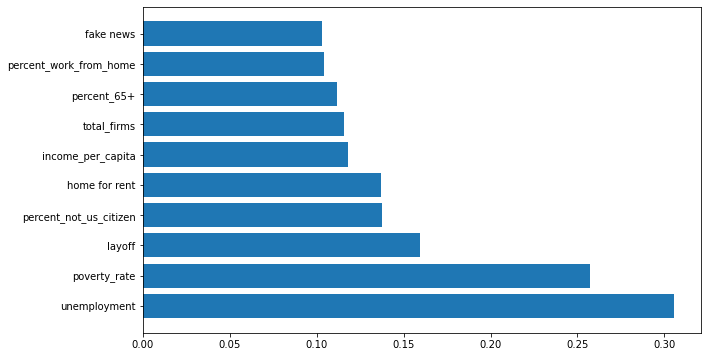


Got an mse at 0.0025 in epoch 45 and stopped training



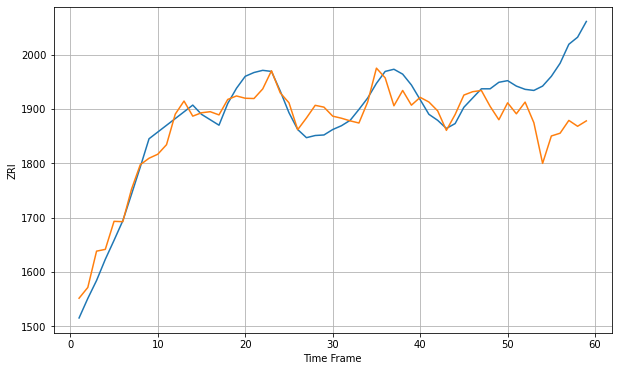

Wall time: 9.65 s
10310 27.572924900469545 109.21594006667166


In [ ]:
score_dict = {"zip":[], "RMSE_train":[], "RMSE_test":[], "importance":[]};
with tf.device('/cpu:0'):
    # for ZONE in zip_ids:
    for ZONE in zip_ids[START_NUM:END_NUM]:
        %time M_train, M_test, model, scaler, series_transformed =\
        NN_test(ZONE, termination=0.0025, plot=True);
        print(ZONE, M_train, M_test);

        score_dict["zip"].append(ZONE);
        score_dict["RMSE_train"].append(M_train);
        score_dict["RMSE_test"].append(M_test);
        
        # Computing the feature importance
        
        results, actual = NN_forecast(model, series_transformed);
        mse = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5;
        perm_importance = [];
        TRIALS = 2;
        PLOT_IMPORTANCE = True;
        
        for i in range(1, len(feature_name)):
            mse_feat = [];
            for _ in range(TRIALS):
                seq_perm = series_transformed.copy();
                seq_perm[:, i] = np.random.permutation(seq_perm[:,i])
                results, actual = NN_forecast(model, seq_perm);
                mse_feat.append(mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5);
                
            perm_importance.append(sum(mse_feat)/TRIALS/mse - 1.0);
        
        importance = pd.DataFrame({"Feature": feature_name[1:], "Importance": perm_importance});
        importance.sort_values("Importance", ascending = False, inplace = True);
        
        plt.figure(figsize=(10, 6));
        plt.barh(importance["Feature"][:10], importance["Importance"][:10]);
        plt.show();
        
        score_dict["importance"].append(perm_importance);

In [ ]:
print(sum(score_dict["RMSE_test"])/len(score_dict["RMSE_test"]));

In [ ]:
test = pd.DataFrame(score_dict);
test.to_csv('NN_feature_window_1_overoverfit_importance_2.csv', index = False);